## Exploratory Data Analisis 

### ATL06 + ATL03 + VIIRS

In this notebook, we are goint to explore what happens in difreent locations of Greenland when we compare the ATL06 flags, the VIIRS flag and the associated measuramests from ATL03 corresponding to a small window around that locations. The ATL06 data is imported as a data frame that can be build from ... . It includes latitude, longitude, height and different flags for different segmensts. 


The VIIRS flag is encoded in the `Integer_Cloud_Mask` and it ranges the values 0 (confidence claud), 1, 2 and 3 (confidence clear), https://ladsweb.modaps.eosdis.nasa.gov/missions-and-measurements/viirs/MODIS_VIIRS_Cloud-Mask_UG_04162020.pdf. 

The ATL06 products counts with its own cloud flags (for example, `cloud_flg_asr`)



In [26]:
from icepyx import icesat2data as ipd
import os
import shutil
from pathlib import Path
from pprint import pprint
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

#%matplotlib inline
%pylab inline

# Fixing figure output for all figures
rcParams['axes.labelsize'] = 9
rcParams['xtick.labelsize'] = 9
rcParams['ytick.labelsize'] = 9
rcParams['legend.fontsize'] = 9
rcParams['figure.dpi'] = 100
rcParams['savefig.dpi'] = 200

from utils_atl03 import *

Populating the interactive namespace from numpy and matplotlib


#### Ploting functions

Here we define a nice palette of colors for both cloud flags. In general, 'blue' colors will make reference to clear conditions and 'green' to cloudy

In [207]:
def cloud_color_ATL(a):
    
    assert a in [1,2,3,4,5], "Your labels are out of the range for this cloud mask"
    
    if a == 1:
        return '#0984e3'
    if a == 2:
        return "#74b9ff"
    if a == 3:
        return "#81ecec"
    if a == 4:
        return "#55efc4"
    if a == 2:
        return '#00b894'
    

def cloud_color_VIIRS(a):
    
    assert a in [0,1,2,3], "Your colors are out of the range for this cloud mask"
    
    if a == 3.0:
        return '#0984e3'
    if a == 2.0:
        return "#74b9ff"
    if a == 1.0:
        return '#55efc4'
    if a == 0.0:
        return '#00b894'

In [ ]:
def hist_df(df, var, by, bins = 50):
    
    classes = unique(df[by])
    
    for c in classes:
        _ = plt.hist( list(df[ df[by] == c ][var] ), bins, alpha = 0.5, label = c )

    plt.title("Histogram of " + str(var) + " grouped by " + str(by))
    plt.legend()
    plt.show
    return None

Read the data and filter those rows without VIIRS cloud mask

In [129]:
atl6 = pd.read_csv("dataframe20200618")
atl6.rename(columns={'Unnamed: 0':'id'}, inplace=True)
atl6 = atl6.set_index("id")
atl6 = atl6[ ~ atl6.Integer_Cloud_Mask.isnull() ]

In [130]:
atl6.head()

,index,ground_track,t_year,lat,lon,Integer_Cloud_Mask,h_li,s_li,q_flag,s_fg,...,cloud_flg_atm,msw_flag,fbsnow_h,bsnow_od,layer_flag,bckgrd,e_bckgrd,n_fit_photons,segment_id,w_surface_window_final
id,,,,,,,,,,,,,,,,,,,,,
169863,0,gt1l,2019-06-05 07:10:03.697914,65.730046,-45.782582,3.0,2392.4720,0.010225,0,0,...,1,4,3.402824e+38,3.402824e+38,0,2405221.5,778052.30,511,365631,3.0
169864,1,gt1l,2019-06-05 07:10:03.700749,65.730225,-45.782631,3.0,2392.3313,0.010640,0,0,...,1,4,3.402824e+38,3.402824e+38,0,2373940.0,778062.90,492,365632,3.0
169865,2,gt1l,2019-06-05 07:10:03.703578,65.730403,-45.782680,3.0,2392.2230,0.010195,0,0,...,1,4,3.402824e+38,3.402824e+38,0,2310990.5,778072.56,484,365633,3.0
169866,3,gt1l,2019-06-05 07:10:03.706398,65.730581,-45.782729,3.0,2392.1213,0.010343,0,0,...,1,4,3.402824e+38,3.402824e+38,0,2313388.5,778082.25,491,365634,3.0
169867,4,gt1l,2019-06-05 07:10:03.709218,65.730760,-45.782778,3.0,2392.0256,0.010727,0,0,...,1,4,3.402824e+38,3.402824e+38,0,2346084.0,778092.80,524,365635,3.0


# Example No1:

As a general recepee, we are going to focus on small regions. The reason for this is that retriving the ATL03 data from varius regions or big areas is not efficient yet. We are going the define the rectangles based on its center (`my_lat` and `my_lon`) and a window in meters (`w`) around it.

In [133]:
my_lat = 66.144
my_lon = -46.114
date_range = ['2019-06-04','2019-06-06']
w = 10000   # This means that my rectangle is a square of side equals to 20km

window_lat = delta_lat(my_lat, my_lon, w)
window_lon = delta_lon(my_lat, my_lon, w) 

Filter the rows of the ATL06 data that are within the selected area 

In [134]:
atl6_1 = atl6 [ (atl6["lat"] < my_lat + window_lat) & (atl6["lon"] < my_lon + window_lon) &
                (atl6["lat"] > my_lat - window_lat) & (atl6["lon"] > my_lon - window_lon) ]

In [135]:
atl6_1

,index,ground_track,t_year,lat,lon,Integer_Cloud_Mask,h_li,s_li,q_flag,s_fg,...,cloud_flg_atm,msw_flag,fbsnow_h,bsnow_od,layer_flag,bckgrd,e_bckgrd,n_fit_photons,segment_id,w_surface_window_final
id,,,,,,,,,,,,,,,,,,,,,
172058,2195,gt1l,2019-06-05 07:10:09.884163,66.121579,-45.891668,3.0,2282.4960,0.011918,0,0,...,0,0,3.402824e+38,3.402824e+38,0,2353547.0,795498.06,488,367826,3.0
172059,2196,gt1l,2019-06-05 07:10:09.887005,66.121758,-45.891719,3.0,2282.4907,0.010612,0,0,...,0,0,3.402824e+38,3.402824e+38,0,2395379.5,795507.75,481,367827,3.0
172060,2197,gt1l,2019-06-05 07:10:09.889852,66.121936,-45.891770,3.0,2282.4912,0.009856,0,0,...,0,0,3.402824e+38,3.402824e+38,0,2436415.0,795518.30,524,367828,3.0
172061,2198,gt1l,2019-06-05 07:10:09.892700,66.122114,-45.891821,3.0,2282.4575,0.010842,0,0,...,0,0,3.402824e+38,3.402824e+38,0,2469994.0,795528.00,537,367829,3.0
172062,2199,gt1l,2019-06-05 07:10:09.895545,66.122293,-45.891872,3.0,2282.3936,0.012820,0,0,...,0,0,3.402824e+38,3.402824e+38,0,2495266.2,795537.70,525,367830,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185864,2820,gt1r,2019-06-05 07:10:11.989109,66.233141,-45.921261,3.0,2260.0693,0.025893,0,0,...,0,0,5.995849e+01,1.146084e-02,0,2273257.0,674625.00,120,368451,3.0
185865,2821,gt1r,2019-06-05 07:10:11.991917,66.233319,-45.921312,3.0,2259.9675,0.026752,0,0,...,0,0,5.995849e+01,1.146084e-02,0,2212609.2,674633.20,127,368452,3.0
185866,2822,gt1r,2019-06-05 07:10:11.994726,66.233498,-45.921363,3.0,2259.8809,0.022690,0,0,...,0,0,5.995849e+01,1.146084e-02,0,2221070.0,674641.30,129,368453,3.0


Here we can see that all the segments in this region are classified as clear sky based on VIIRS

In [106]:
np.unique( atl6_1.Integer_Cloud_Mask, return_counts=True )

(array([3.]), array([1221]))

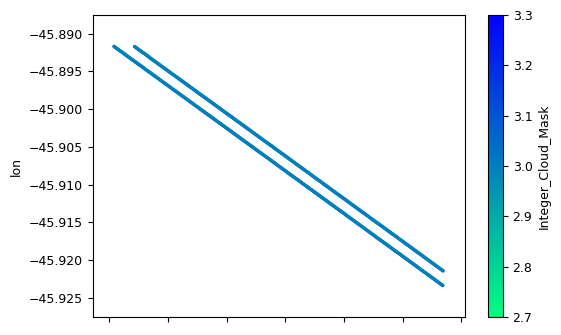

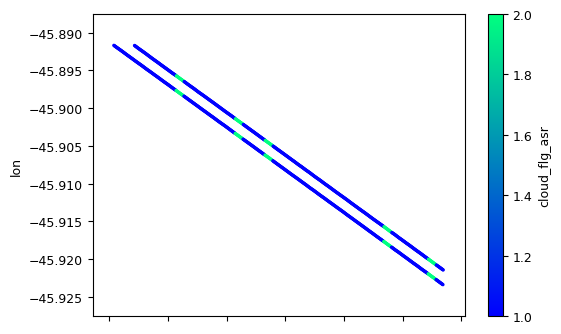

In [208]:
ax1 = atl6_1.plot.scatter(x='lat',
                          y='lon',
                          c='Integer_Cloud_Mask',
                          s = 2,  colormap='winter_r')
ax2 = atl6_1.plot.scatter(x='lat',
                          y='lon',
                          c='cloud_flg_asr',
                          s = 2,  colormap='winter')

#### ATL03 Retrieval

<div>
<img src="https://earthobservatory.nasa.gov/blogs/earthmatters/wp-content/uploads/sites/5/2018/10/PHOTON_JUMP_FINAL_SND4_NewPP_720.jpg" align="right" width="300"/>
</div>

As it was mentioned before, the current implementation of the ATL03 retrieval just allows unique calls in order to retrieve individual photons for a given region. There is a way of doing multiple calls using a for loop (see `multiple__read_atl03` in `utils_atl03.py`) but it requires to login in EarthData at each single call. These is a way to avoid this (To Do)

`pho` is a pandas dataframe where each row corresponds to a single photon, and columns include latitude, longitud and height  

In [35]:
pho = read_atl03(my_lat, my_lon, date_range, w)

Earthdata Login password:  ···········


Total number of data order requests is  1  for  1  granules.
Data request  1  of  1  is submitting to NSIDC
order ID:  5000000708185
Initial status of your order request at NSIDC is:  processing
Your order status is still  processing  at NSIDC. Please continue waiting... this may take a few moments.
Your order is: complete
Beginning download of zipped output...
Data request 5000000708185 of  1  order(s) is downloaded.
Download complete


In [36]:
pho

,h_ph,lon_ph,lat_ph
0,2269.713623,-45.891638,66.121464
1,2275.261963,-45.891638,66.121470
2,2277.833984,-45.891638,66.121470
3,2282.625244,-45.891639,66.121476
4,2282.720703,-45.891639,66.121476
...,...,...,...
237656,2259.723633,-45.921465,66.233851
237657,2268.336670,-45.921464,66.233852
237658,2258.289062,-45.921465,66.233851
237659,2259.622070,-45.921465,66.233851


#### ATL03 Mathching

Once we retrieved the photons for the regions that includes all the rows in our dataframe, we proceed to assign each row to the  respective photons. To do that, we reduce the window to w = 50 meters and we create a dictonary that maps the index of the original dataframe to a relative small dataframes with the location and height of each individual photon inside the window (~400 for the weak beam and ~1500 for the strong beam).

We also can add more columns to the original dataframes based on the retrieved photons from ATL03. Right now, I am using

- `atl3_std`:The standard desviation in height of the photons. This shows to be a good indicator of how disperse are the photons. Small values typically corresponds to regions where the surface is easy to distinguish.

- `n_photons`: Number of photons inside the window

0


/Users/facundosapienza/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/facundosapienza/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


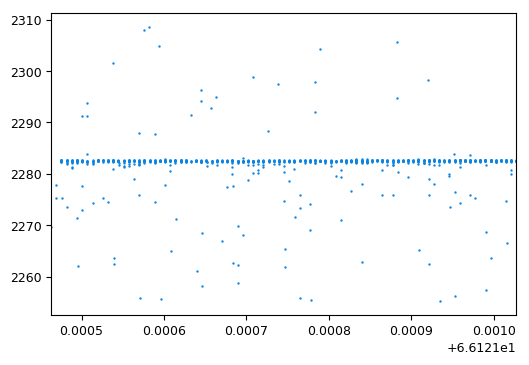

100


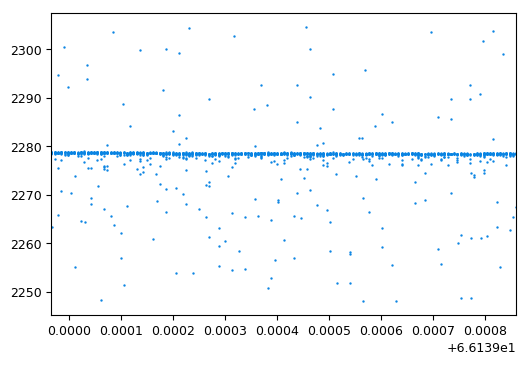

200


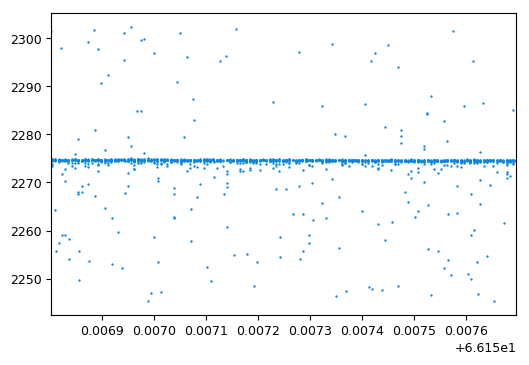

300


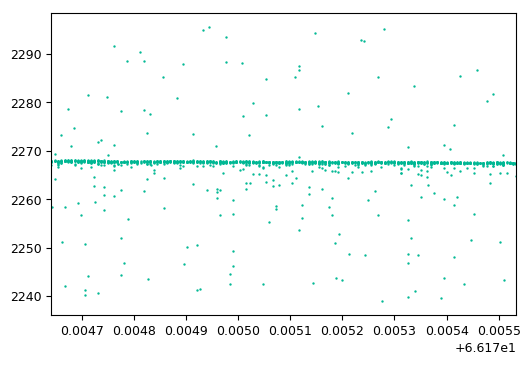

400


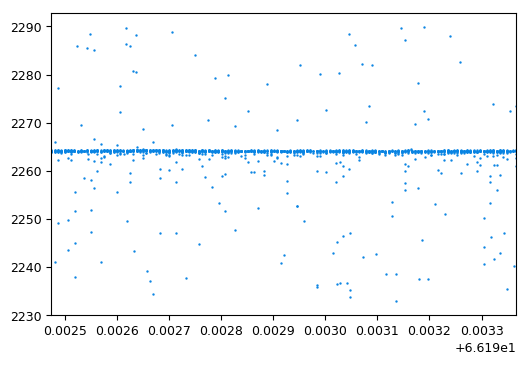

500


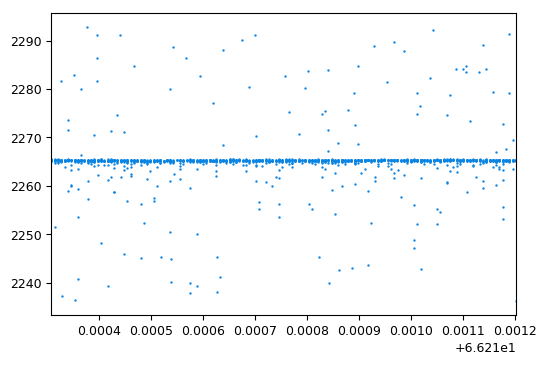

600


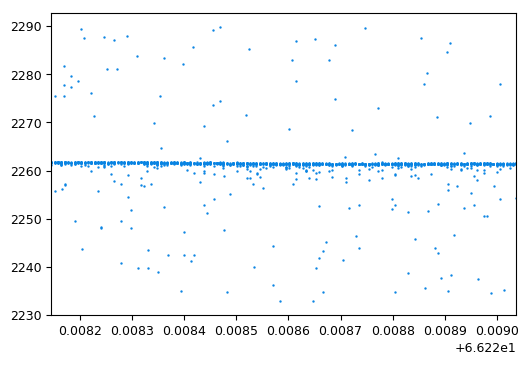

700


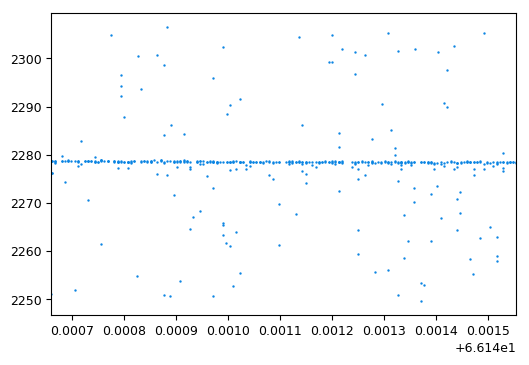

800


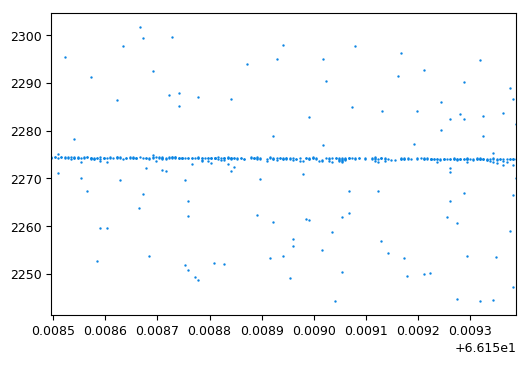

900


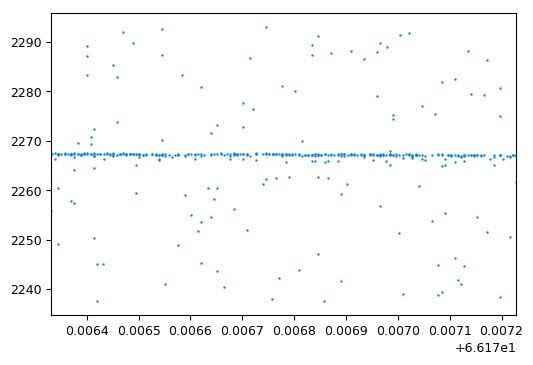

1000


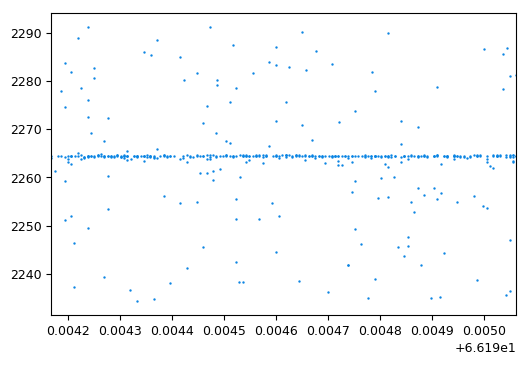

1100


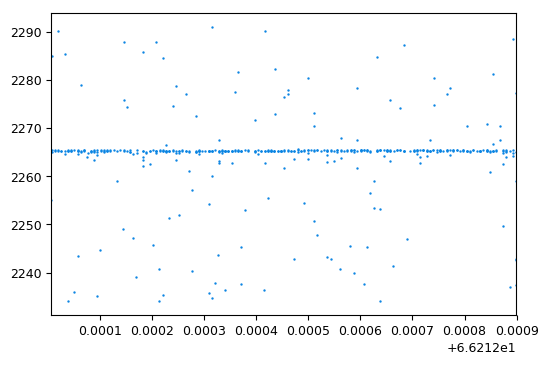

1200


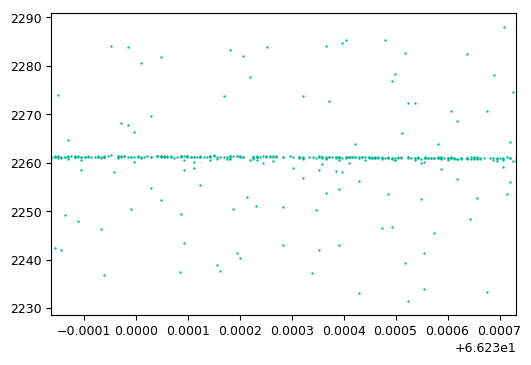

In [183]:
atl3_1 = {}
atl6_1["atl3_std"] = None
atl6_1["n_photons"] = None
 
# new small window
window_lat = delta_lat(my_lat, my_lon, 50)
window_lon = delta_lon(my_lat, my_lon, 50)   

for j, i in enumerate(atl6_1.index):
            
    my_row = atl6_1.loc[i]
    
    
    lat = float(my_row.lat)
    lon = float(my_row.lon)
    
    df = pho [ (pho["lat_ph"] < lat + window_lat) & (pho["lon_ph"] < lon + window_lon) &
               (pho["lat_ph"] > lat - window_lat) & (pho["lon_ph"] > lon - window_lon) ]
    
    atl3_1[i] = df
    
    if j % 100 == 0:
        print(j)
        #ax2 = plt.scatter(df.lat_ph, df.h_ph, s = 0.5, c = cloud_color_VIIRS(float(my_row.Integer_Cloud_Mask)))
        ax2 = plt.scatter(df.lat_ph, df.h_ph, s = 0.5, c = cloud_color_ATL(float(my_row.cloud_flg_asr))) 
        plt.xlim([min(df.lat_ph), max(df.lat_ph)])
        plt.show()
    
    ## Extra columns on the original ATL06 file
    
    atl6_1.loc[i, "atl3_std"] = np.std(df.h_ph)
    atl6_1.loc[i, "n_photons"] = df.shape[0]

#### Analysis

We observe that values of small and large standard desviation correspond to different beams. After a simple analysis, we can see that the standard desviation of the strong beam is smaller that the one of the weak beam, and both distributions (std for strong and std for weak) are simple to distinguish. Recall that in this example we have a clear sky, so the level of noise is relatively small and in all cases we can see the surface of the ice.

This could be an important difference between the two beams. Reason why this could be happening:

1) The relative proportion of background photons is larger for the weak beam respect to the strong beam

2) The precision of the height of a single photon depends of the intensity of the beam (it does not have much sense, but maybe there is something in the procession of the data)


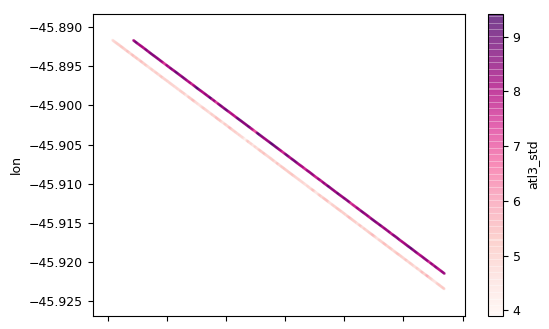

In [141]:
ax2 = atl6_1.plot.scatter(x='lat',
                        y='lon',
                        c='atl3_std',
                        s = 1,  colormap='RdPu', alpha = 0.5)

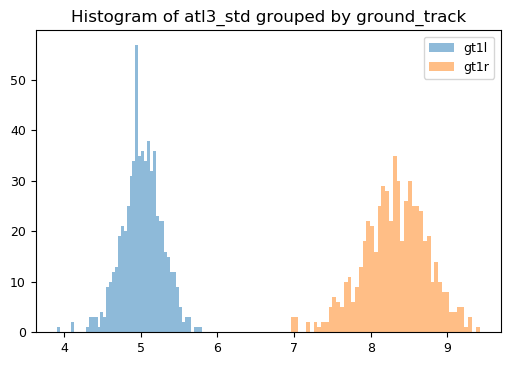

In [178]:
hist_df(atl6_1, "atl3_std", "ground_track")

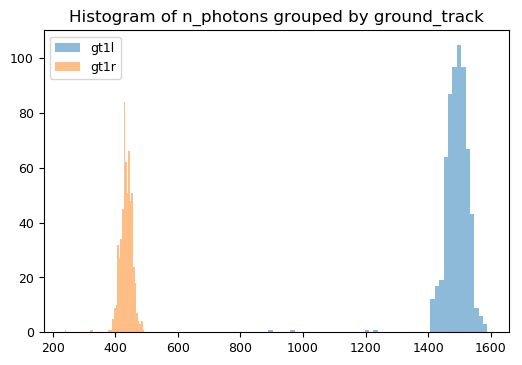

In [180]:
hist_df(atl6_1, "n_photons", "ground_track")

Notice that there is no obvious relation between the flags from ATL06 and the standard desviation of the photons

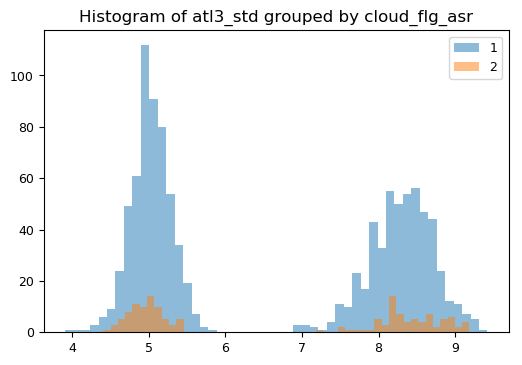

In [185]:
hist_df(atl6_1, "atl3_std", "cloud_flg_asr")

# Example No2

In [201]:
my_lat = 66.444
my_lon = -46.614
date_range = ['2019-06-08','2019-06-10']
w = 10000

window_lat = delta_lat(my_lat, my_lon, w)
window_lon = delta_lon(my_lat, my_lon, w) 

In [202]:
atl6_2 = atl6 [ (atl6["lat"] < my_lat + window_lat) & (atl6["lon"] < my_lon + window_lon) &
                (atl6["lat"] > my_lat - window_lat) & (atl6["lon"] > my_lon - window_lon) ]

In [203]:
np.unique( atl6_2.Integer_Cloud_Mask, return_counts=True )

(array([0., 3.]), array([5498,  552]))

Now, for this other example we have that, according to VIIRS, most of the the measuramets are label as clouds (green in the upper gruph). However, `cloud_flg_asr` shows a more rich behavior. In general seems to identyfy the area with no clouds. As we are going to see, even when we have the cloud mask for VIIRS activated, we are going to be able to identify the surface of the ice sheet for some cases

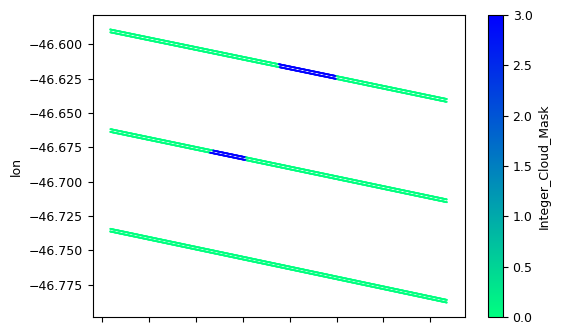

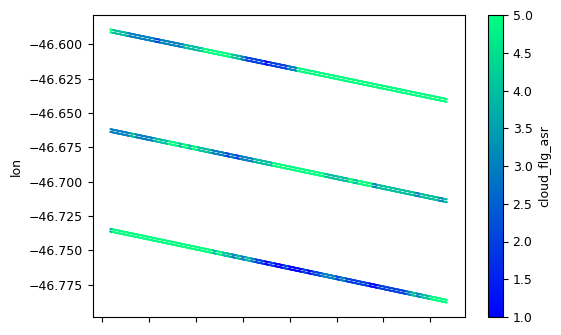

In [204]:
ax1 = atl6_2.plot.scatter(x='lat',
                          y='lon',
                          c='Integer_Cloud_Mask',
                          s = 0.1,  colormap='winter_r')
ax2 = atl6_2.plot.scatter(x='lat',
                          y='lon',
                          c='cloud_flg_asr',
                          s = 0.1,  colormap='winter')

In [205]:
pho = read_atl03(my_lat, my_lon, date_range, w)

Earthdata Login password:  ···········


Total number of data order requests is  1  for  1  granules.
Data request  1  of  1  is submitting to NSIDC
order ID:  5000000708232
Initial status of your order request at NSIDC is:  processing
Your order status is still  processing  at NSIDC. Please continue waiting... this may take a few moments.
Your order status is still  processing  at NSIDC. Please continue waiting... this may take a few moments.
Your order is: complete
Beginning download of zipped output...
Data request 5000000708232 of  1  order(s) is downloaded.
Download complete


0


/Users/facundosapienza/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/facundosapienza/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


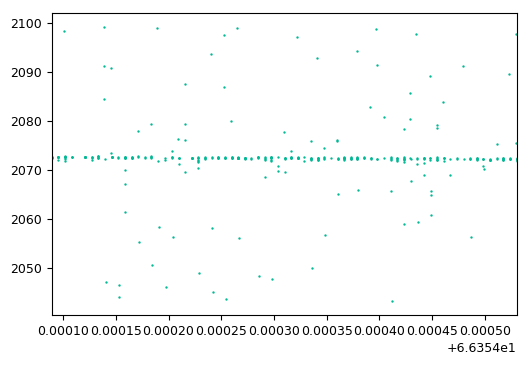

100


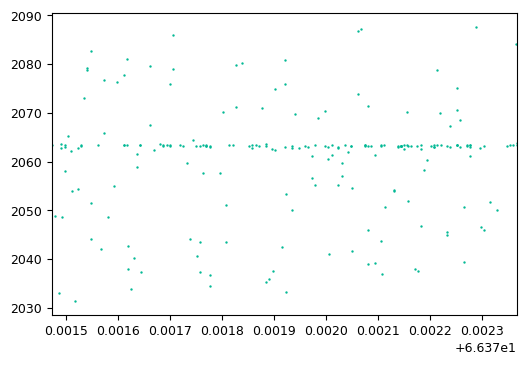

200


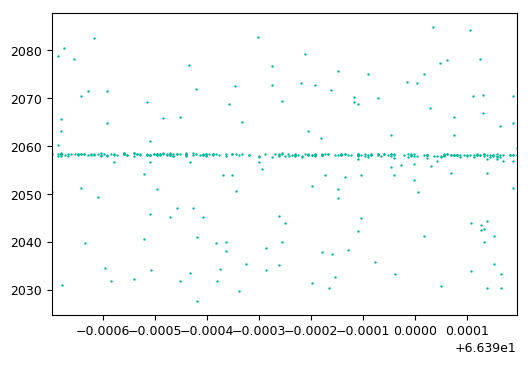

300


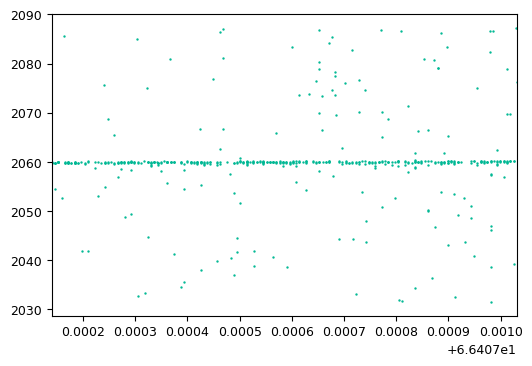

400


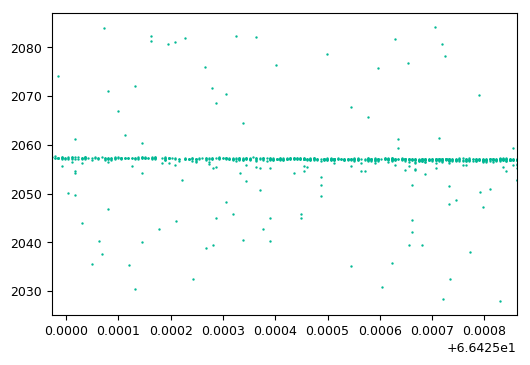

500


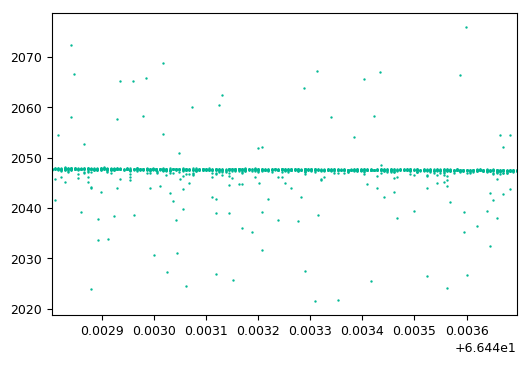

600


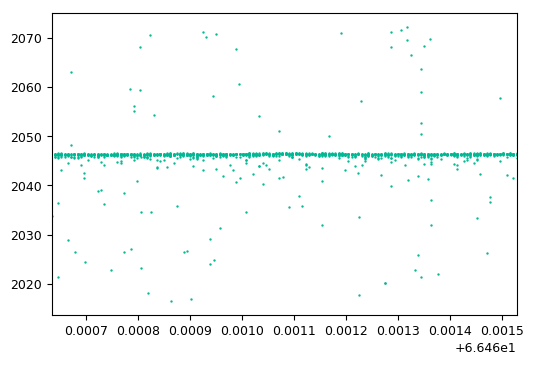

700


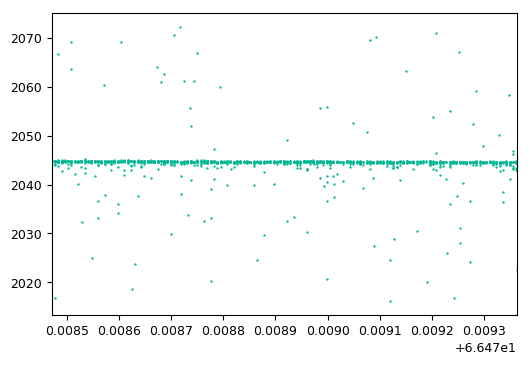

800


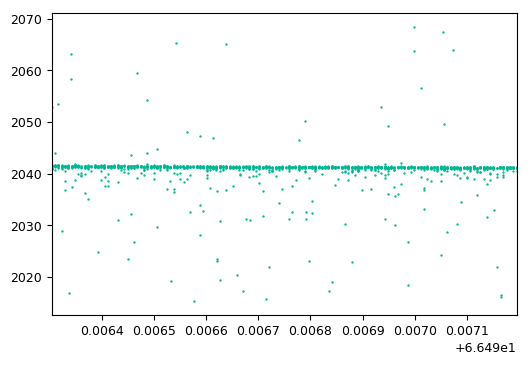

900


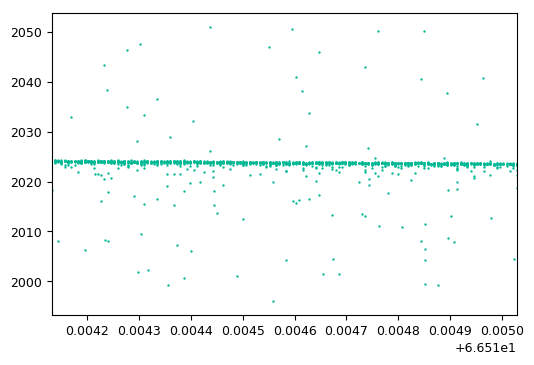

1000


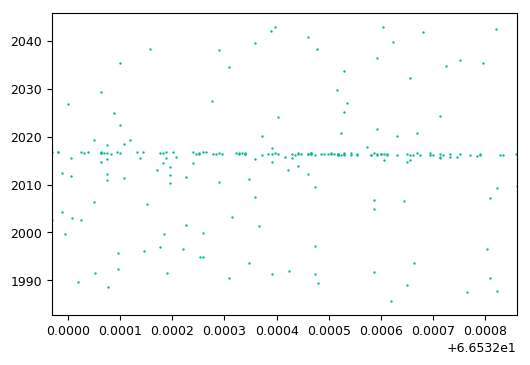

1100


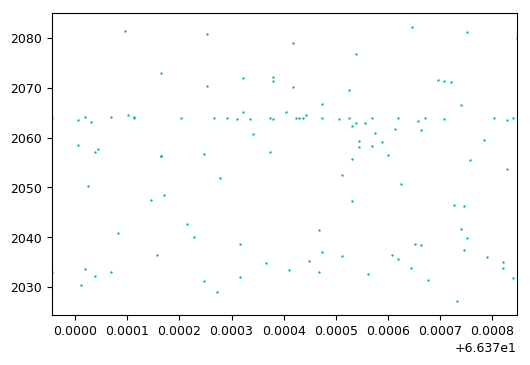

1200


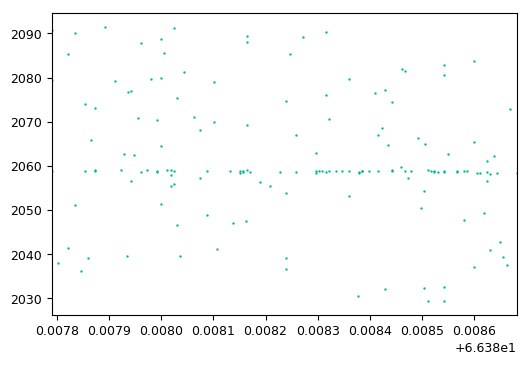

1300


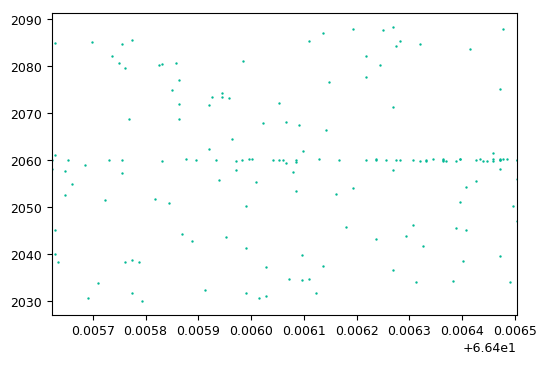

1400


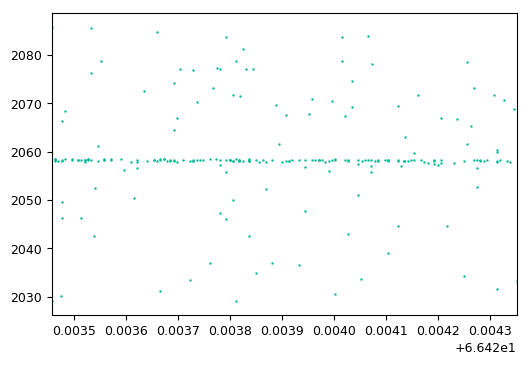

1500


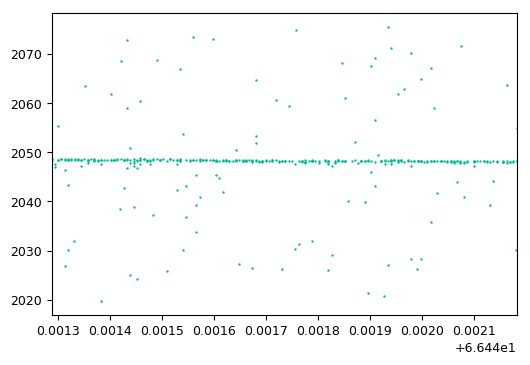

1600


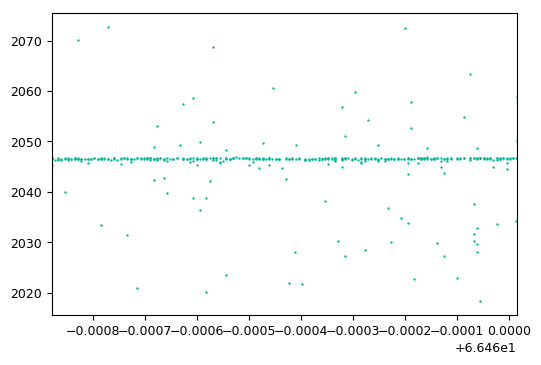

1700


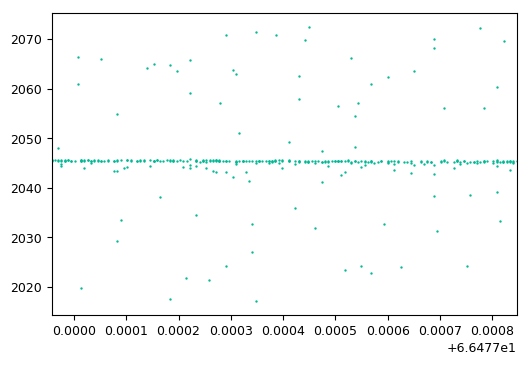

1800


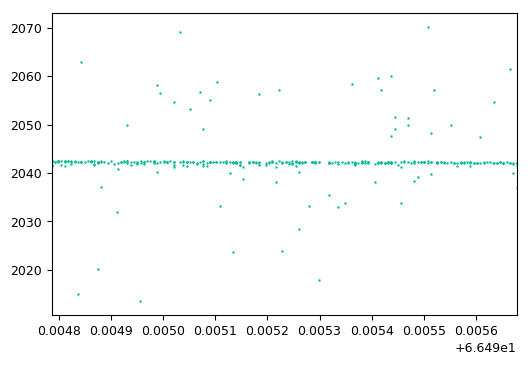

1900


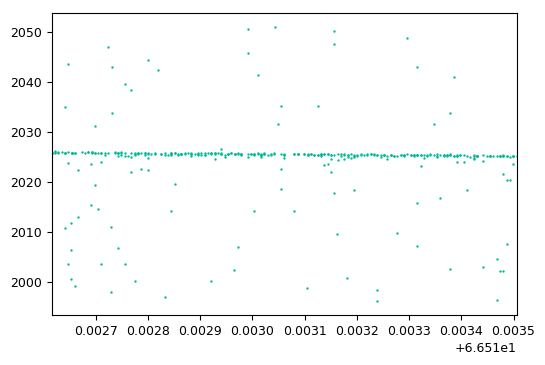

2000


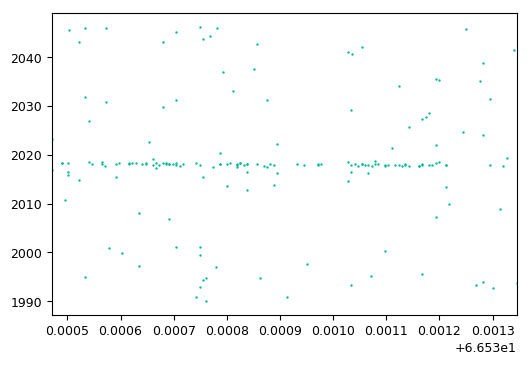

2100


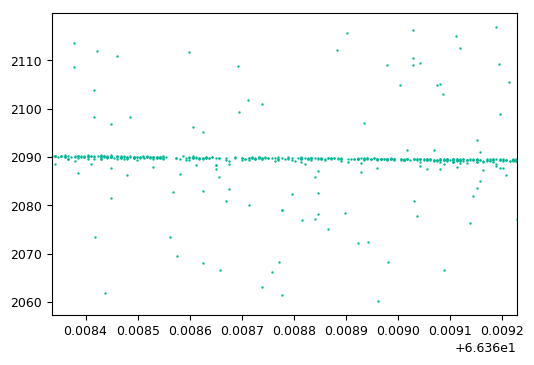

2200


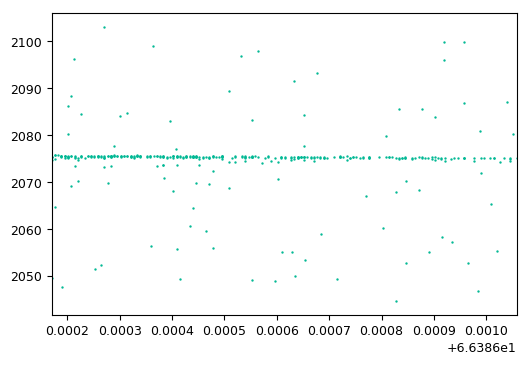

2300


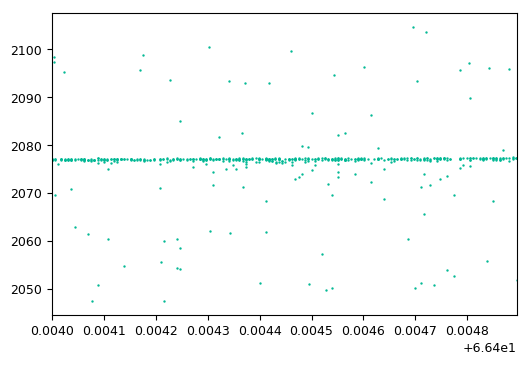

2400


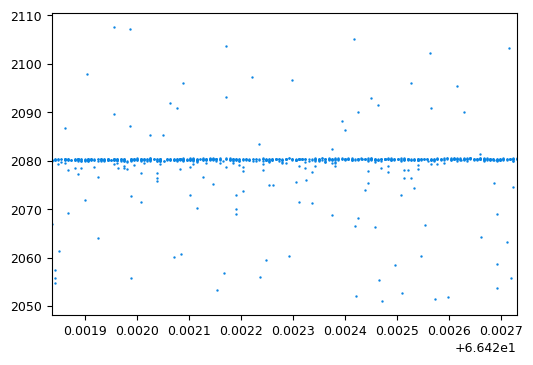

2500


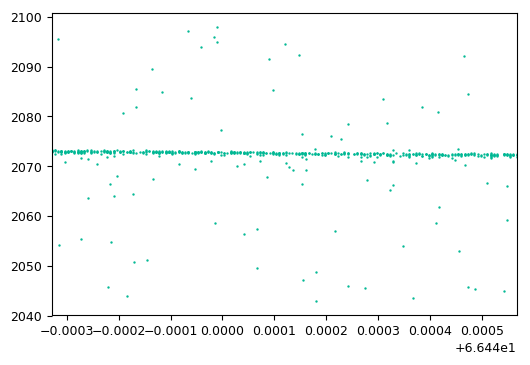

2600


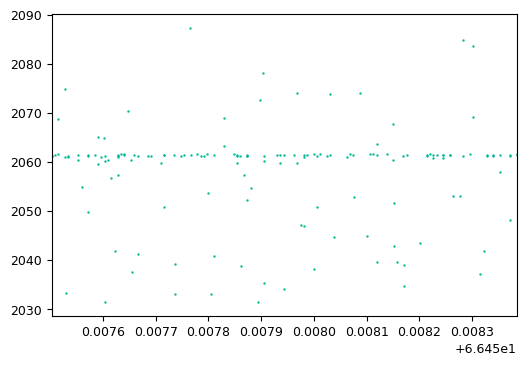

2700


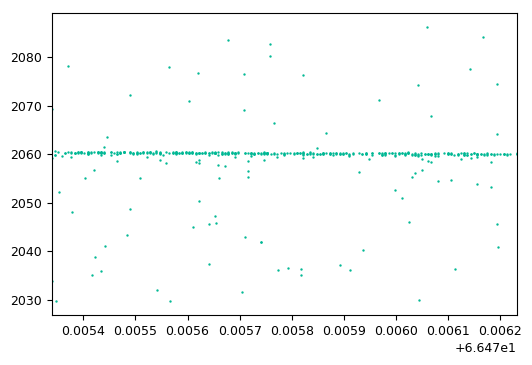

2800


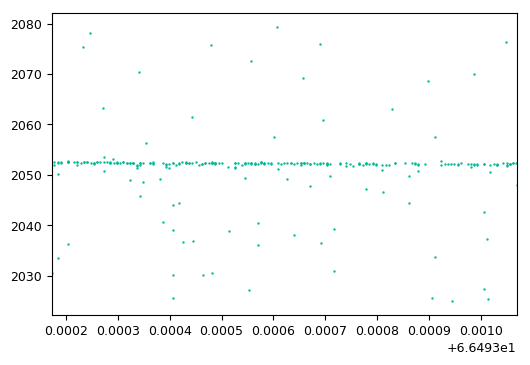

2900


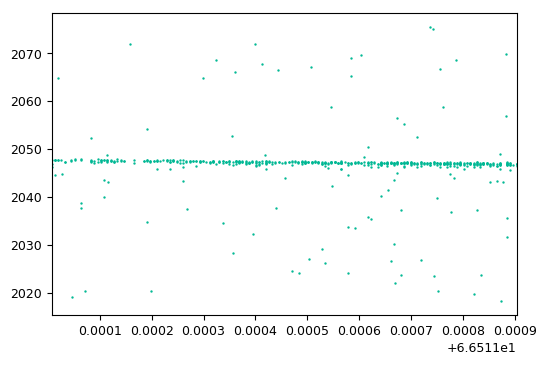

3000


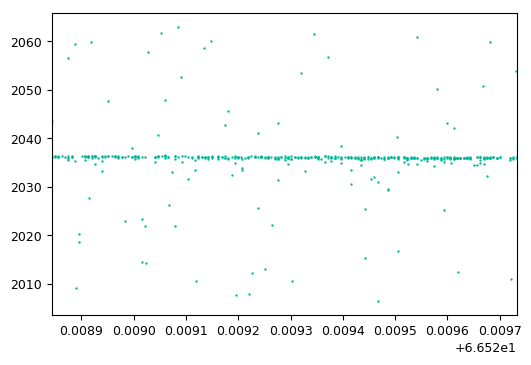

3100


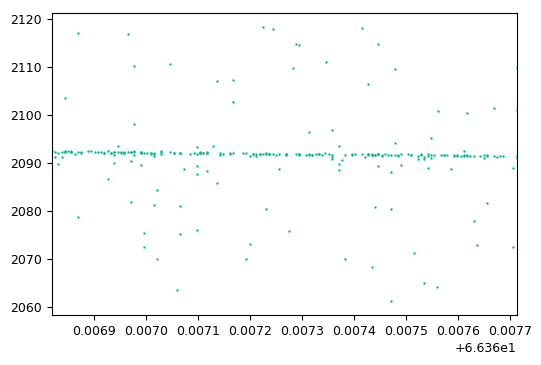

3200


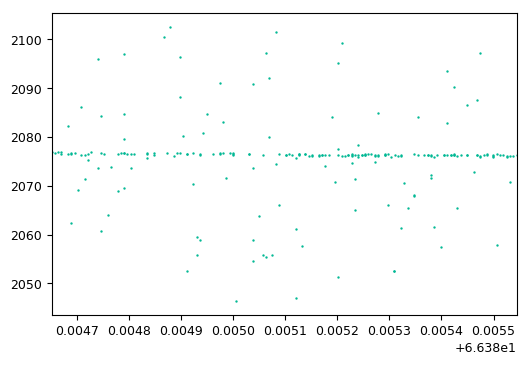

3300


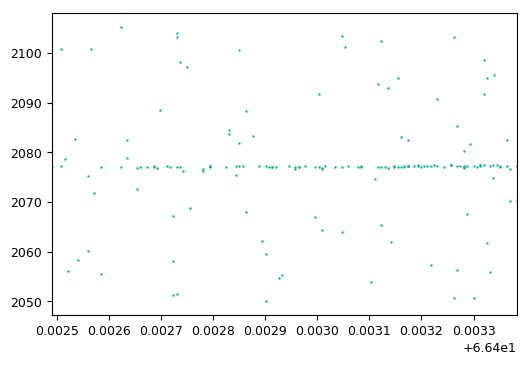

3400


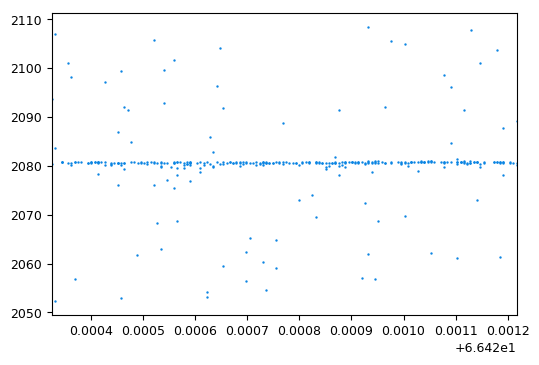

3500


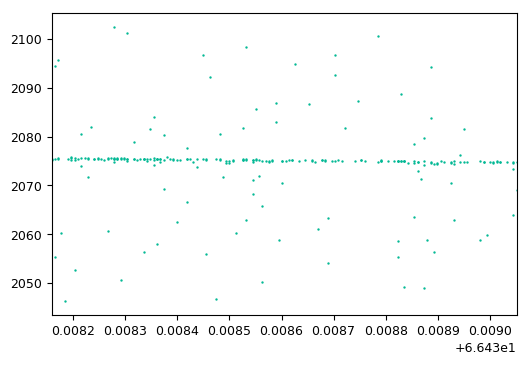

3600


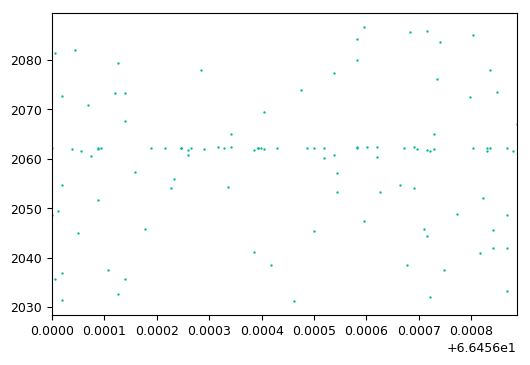

3700


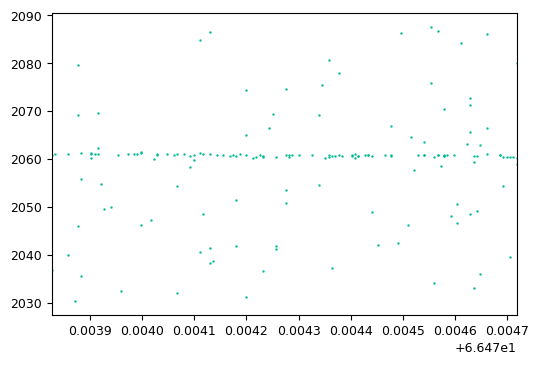

3800


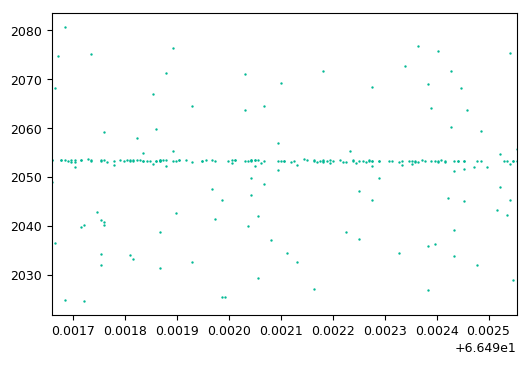

3900


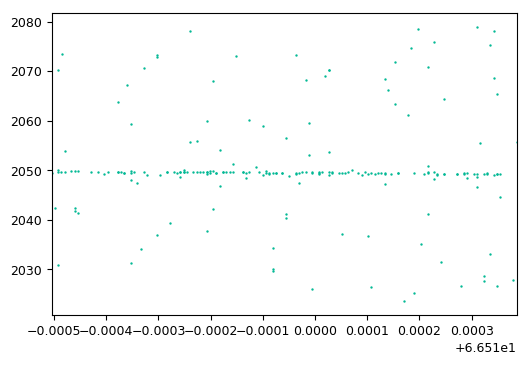

4000


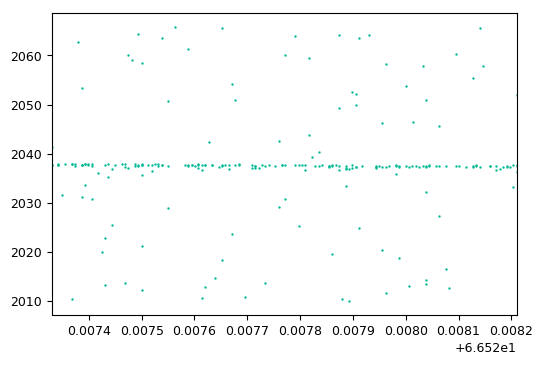

4100


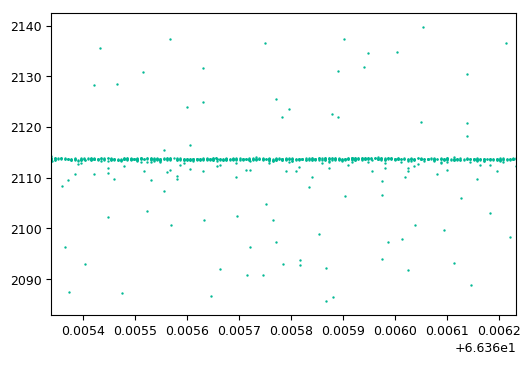

4200


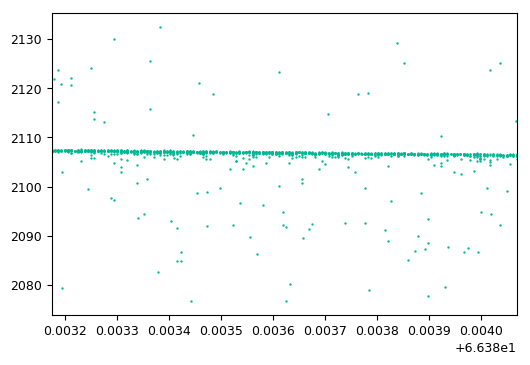

4300


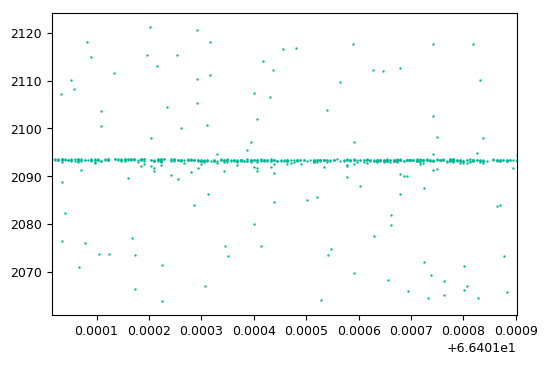

4400


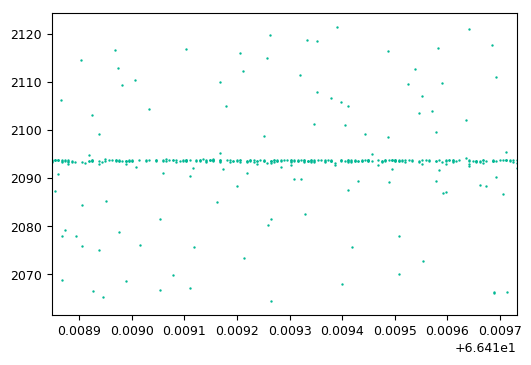

4500


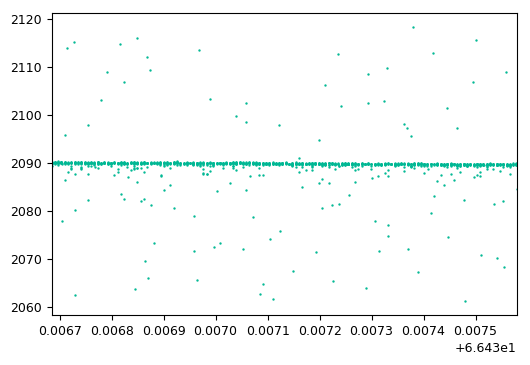

4600


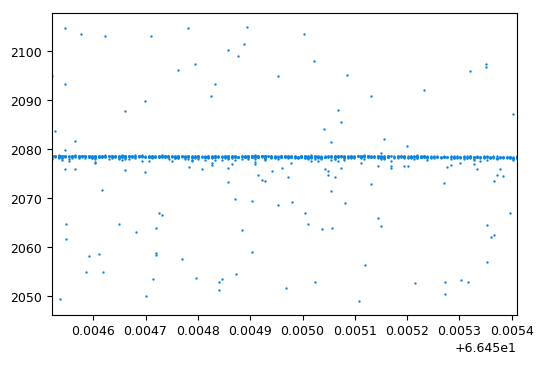

4700


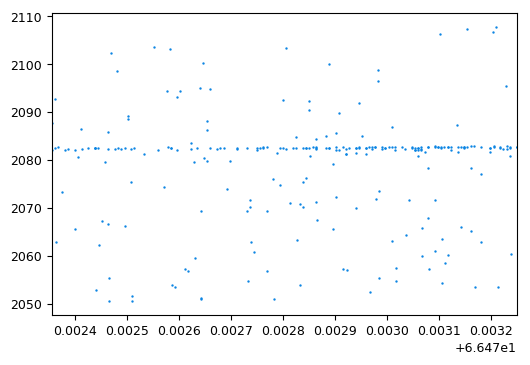

4800


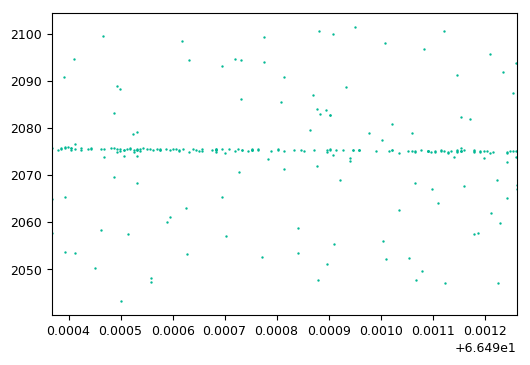

4900


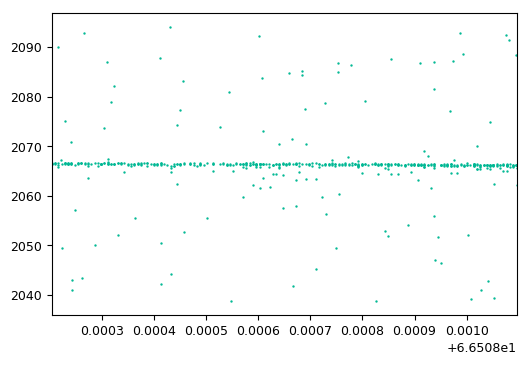

5000


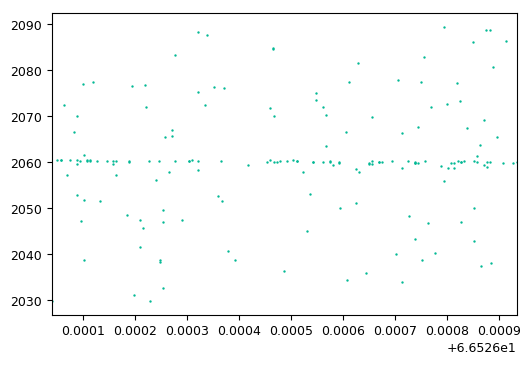

5100


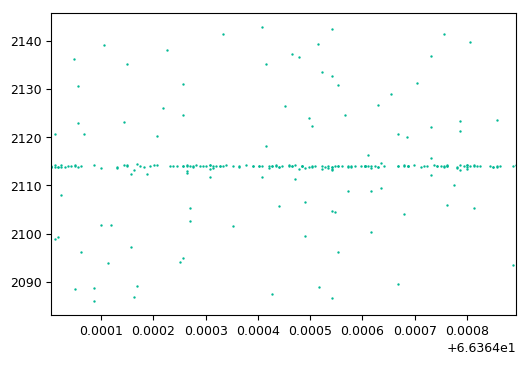

5200


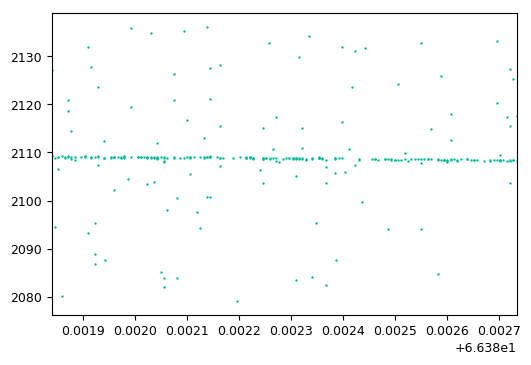

5300


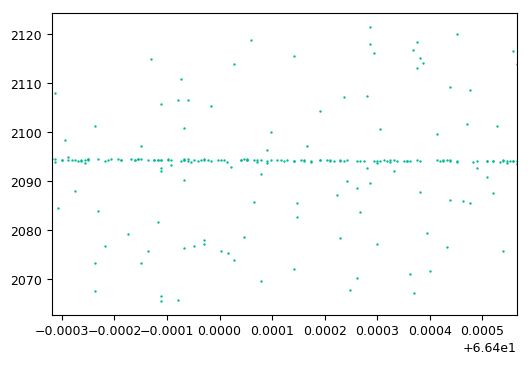

5400


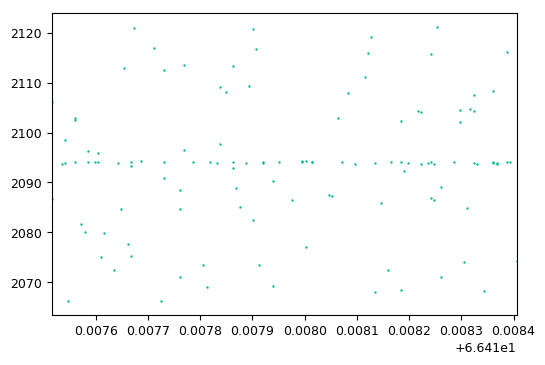

5500


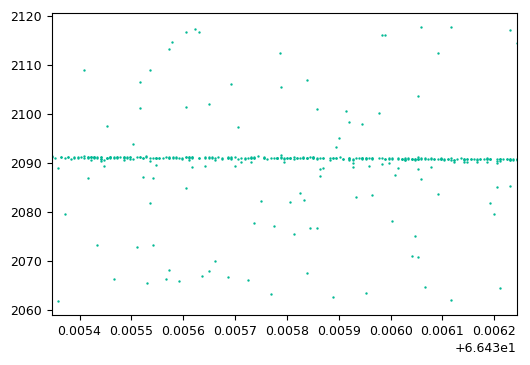

5600


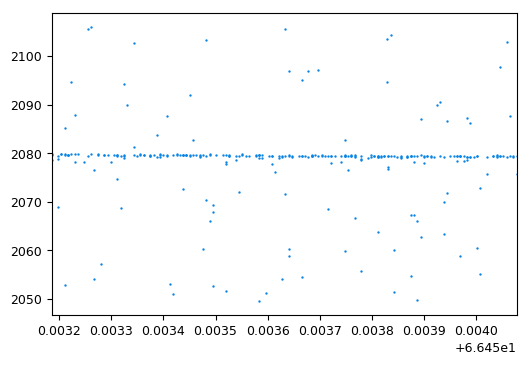

5700


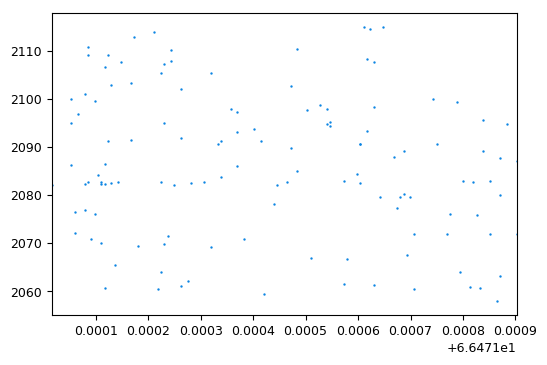

5800


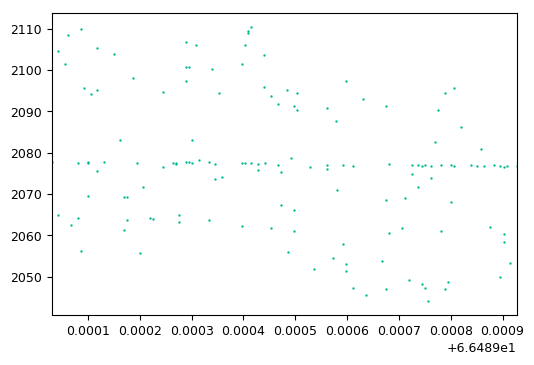

5900


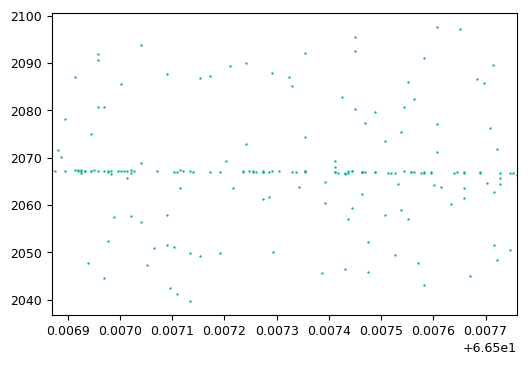

6000


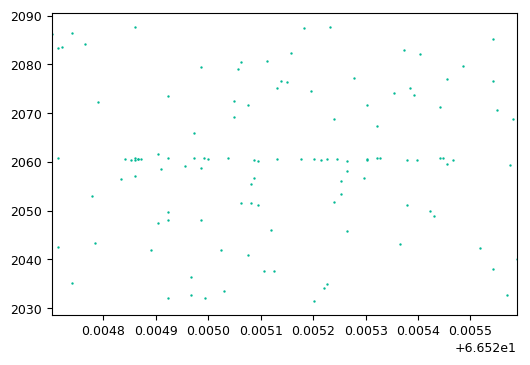

In [210]:
atl3_2 = {}
atl6_2["atl3_std"] = None
atl6_2["n_photons"] = None
 
# new small window
window_lat = delta_lat(my_lat, my_lon, 50)
window_lon = delta_lon(my_lat, my_lon, 50)   

for j, i in enumerate(atl6_2.index):
            
    my_row = atl6_2.loc[i]
    
    
    lat = float(my_row.lat)
    lon = float(my_row.lon)
    
    df = pho [ (pho["lat_ph"] < lat + window_lat) & (pho["lon_ph"] < lon + window_lon) &
               (pho["lat_ph"] > lat - window_lat) & (pho["lon_ph"] > lon - window_lon) ]
    
    atl3_2[i] = df
    
    if j % 100 == 0:
        print(j)
        ax2 = plt.scatter(df.lat_ph, df.h_ph, s = 1, c = cloud_color_VIIRS(float(my_row.Integer_Cloud_Mask)))
        #ax2 = plt.scatter(df.lat_ph, df.h_ph, s = 1, c = cloud_color_ATL(float(my_row.cloud_flg_asr))) 
        plt.xlim([min(df.lat_ph), max(df.lat_ph)])
        plt.show()
    
    ## Extra columns on the original ATL06 file
    
    atl6_2.loc[i, "atl3_std"] = np.std(df.h_ph)
    atl6_2.loc[i, "n_photons"] = df.shape[0]

From the following plot we can see that the clear regions form VIIRS have small standard desviation. However, we see that the patern in the standard desviations is in agreement with the ATL flag, which is something that we expected 

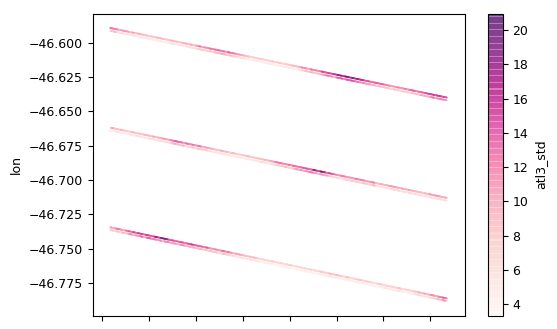

In [212]:
ax2 = atl6_2.plot.scatter(x='lat',
                        y='lon',
                        c='atl3_std',
                        s = 0.1,  colormap='RdPu', alpha = 0.5)

Now, when we plot the distribition of the 2x3 = 6 beamns, we see a more complex distribution. However, if we plot one histogram for each ground track, we can see that the complexity arises from the combination of the different typical values of standard desviation between beams. Just as before, the weak beam seems to have larger values of standard desviation.  

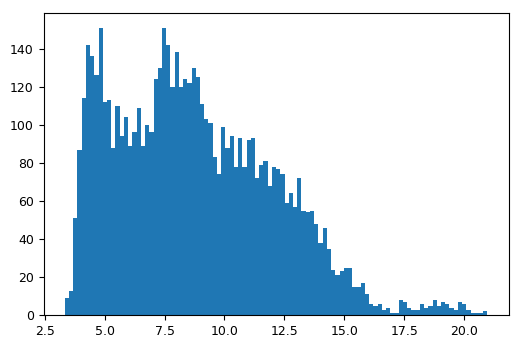

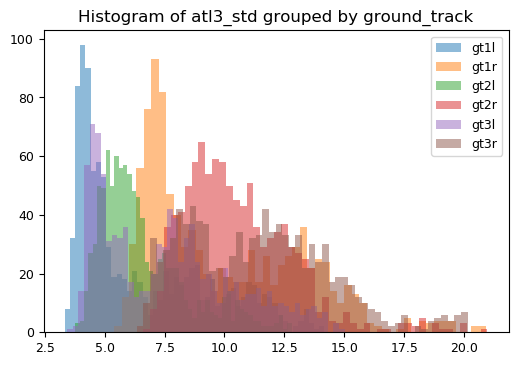

In [218]:
plt.hist(list(atl6_2.atl3_std), 100)
plt.show()
hist_df(atl6_2, "atl3_std", "ground_track")

As we alredy saw, the standard desviation seems to be a good indicator or predictor for `cloud_flg_asr`. For VIIRS, we did not observe any significative difference between the distribution when we use `Integer_Cloud_Mask` to split the data.

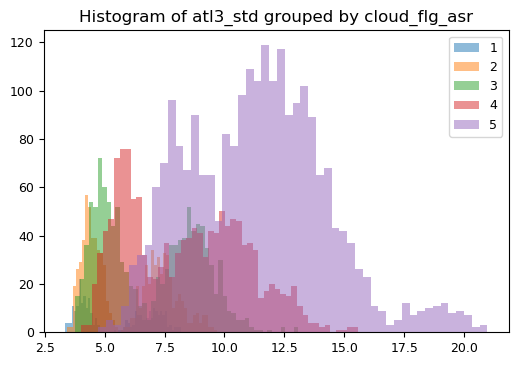

In [222]:
hist_df(atl6_2, "atl3_std", "cloud_flg_asr")

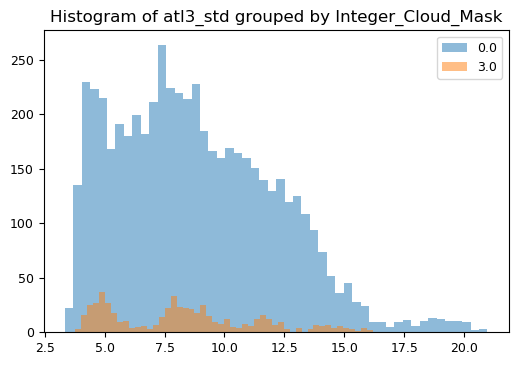

In [223]:
hist_df(atl6_2, "atl3_std", "Integer_Cloud_Mask")

# Example No3

In [235]:
my_lat = 66.244
my_lon = -46.714
date_range = ['2019-06-08','2019-06-10']
w = 10000

window_lat = delta_lat(my_lat, my_lon, w)
window_lon = delta_lon(my_lat, my_lon, w)    

In [236]:
atl6_3 = atl6 [ (atl6["lat"] < my_lat + window_lat) & (atl6["lon"] < my_lon + window_lon) &
                (atl6["lat"] > my_lat - window_lat) & (atl6["lon"] > my_lon - window_lon) ]

In [238]:
pho = read_atl03(my_lat, my_lon, date_range, w)

Earthdata Login password:  ···········


Total number of data order requests is  1  for  1  granules.
Data request  1  of  1  is submitting to NSIDC
order ID:  5000000708234
Initial status of your order request at NSIDC is:  processing
Your order status is still  processing  at NSIDC. Please continue waiting... this may take a few moments.
Your order is: complete
Beginning download of zipped output...
Data request 5000000708234 of  1  order(s) is downloaded.
Download complete


/Users/facundosapienza/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/facundosapienza/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0


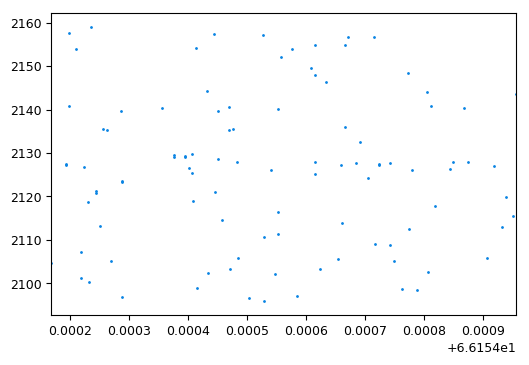

/Users/facundosapienza/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


100


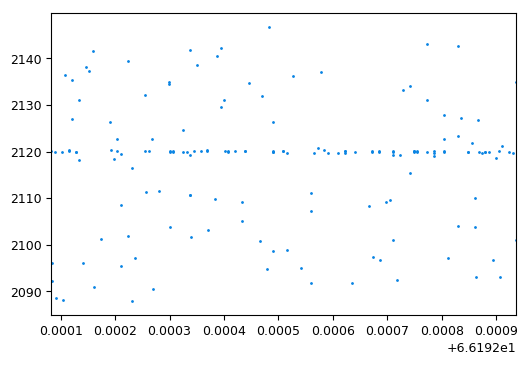

200


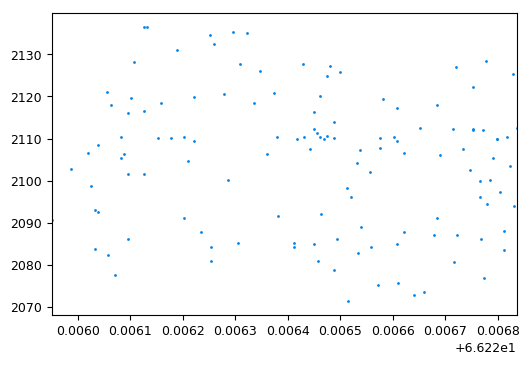

300


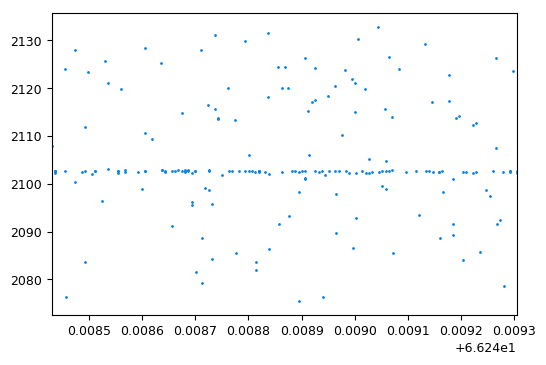

400


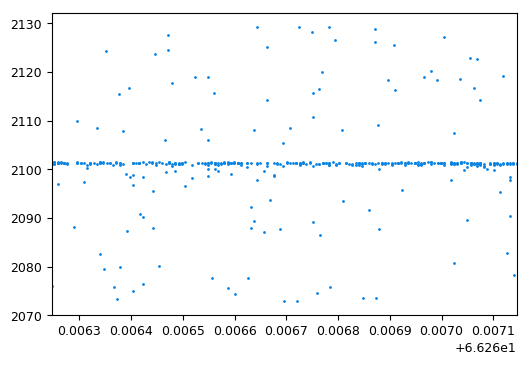

500


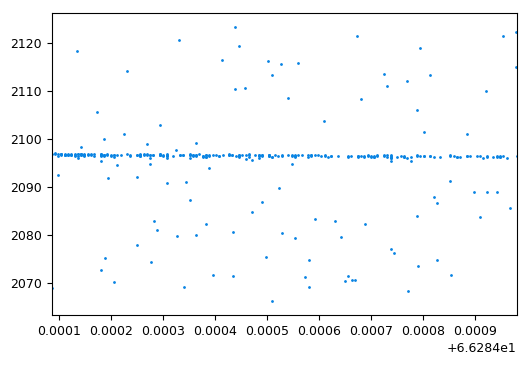

600


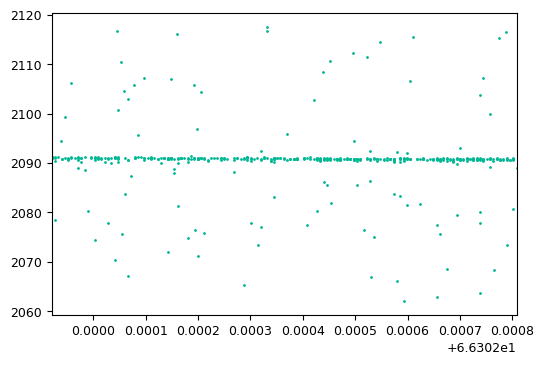

700


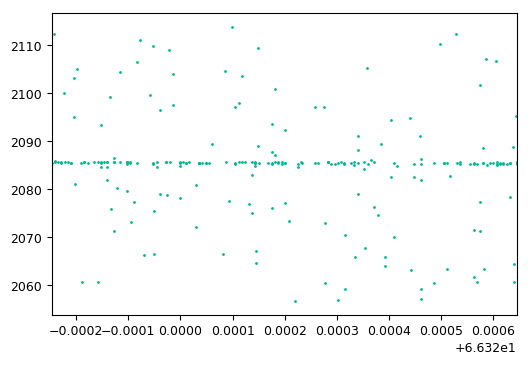

800


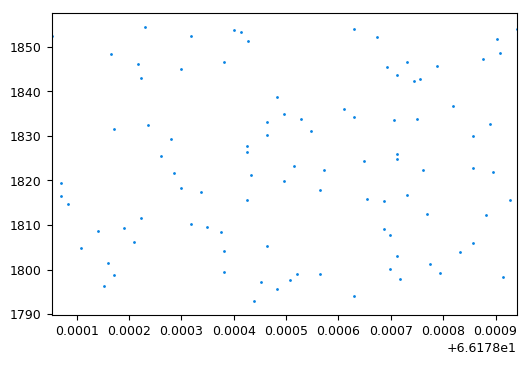

900


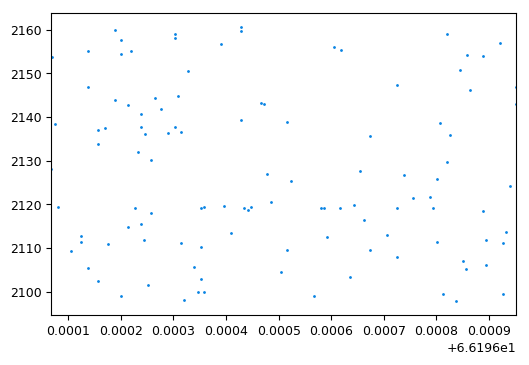

1000


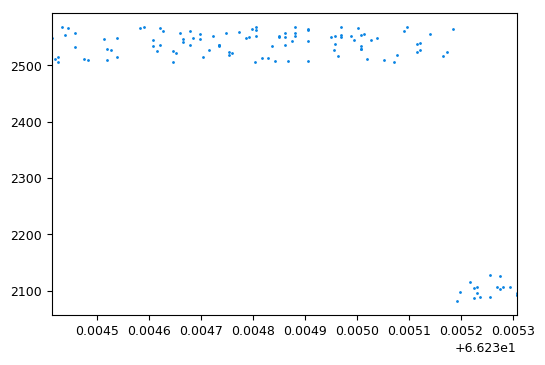

1100


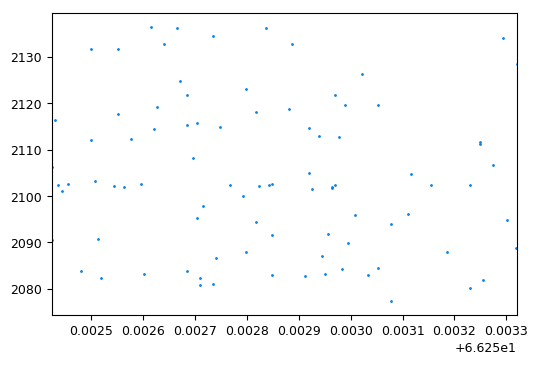

1200


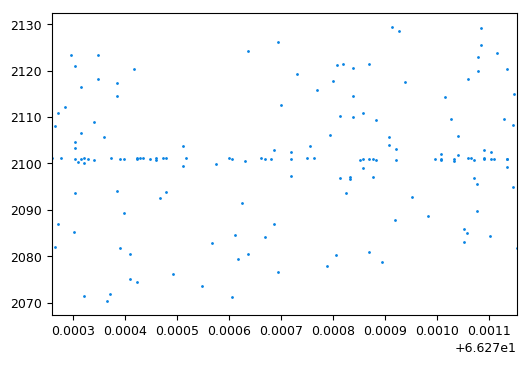

1300


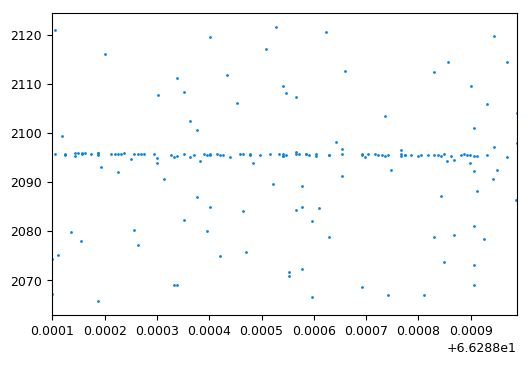

1400


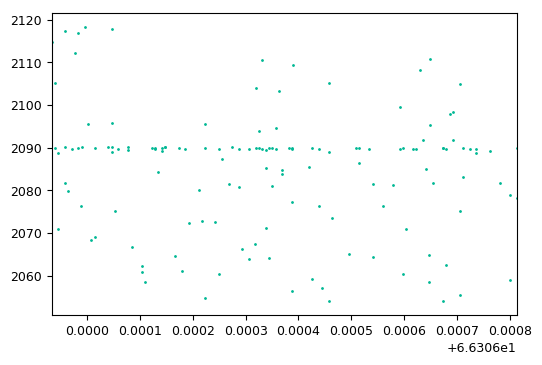

1500


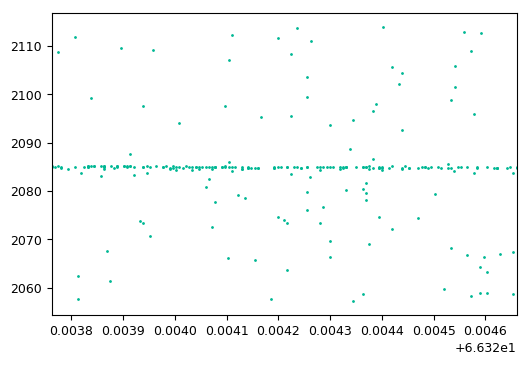

1600


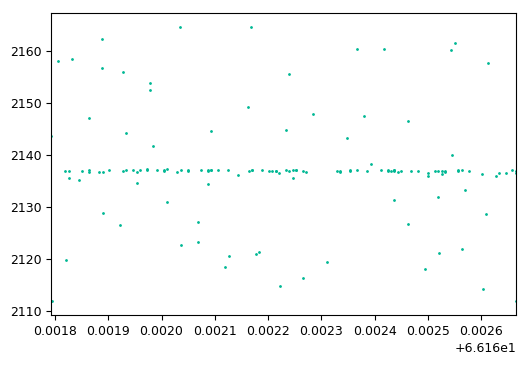

1700


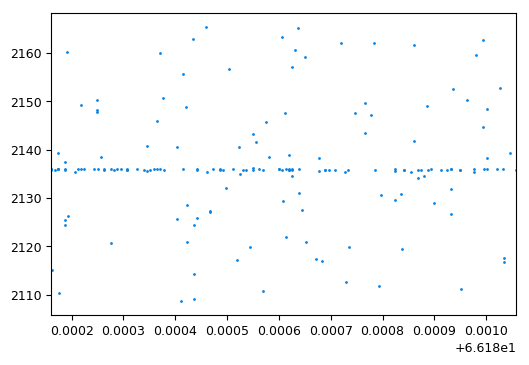

1800


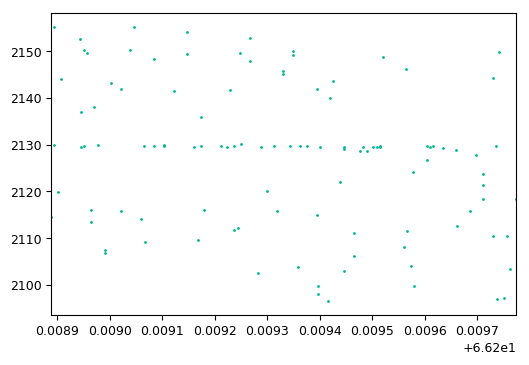

1900


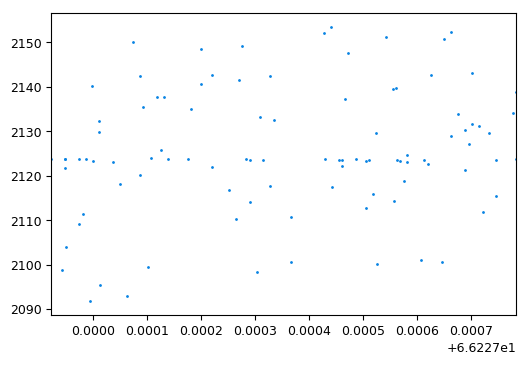

2000


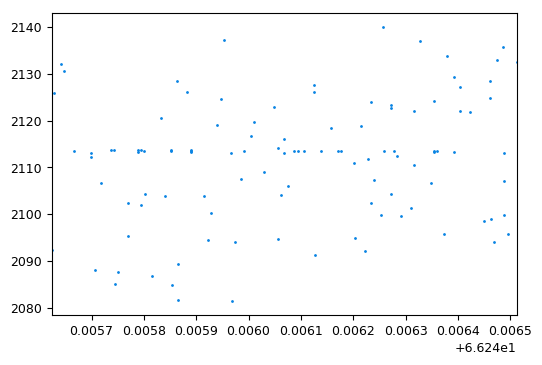

2100


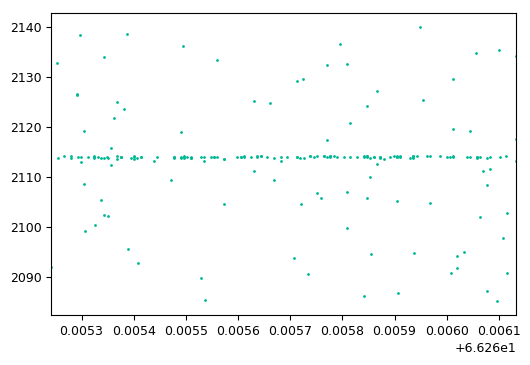

2200


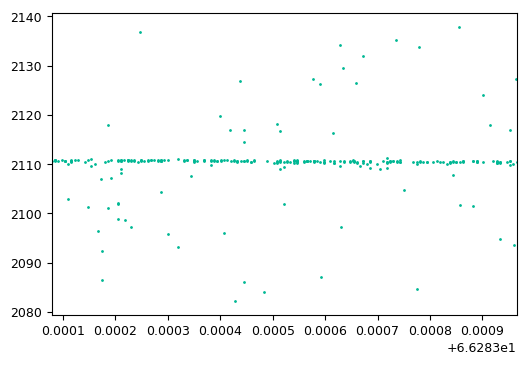

2300


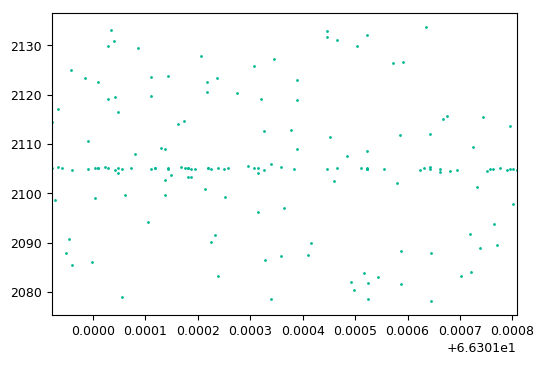

2400


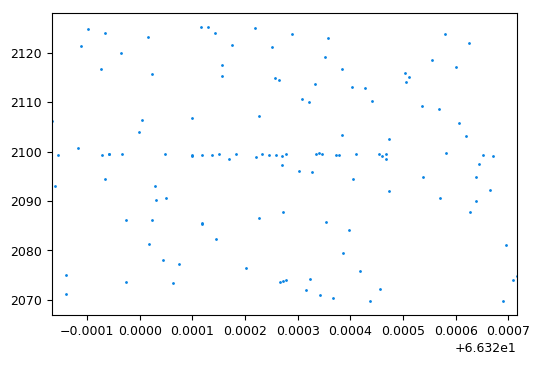

2500


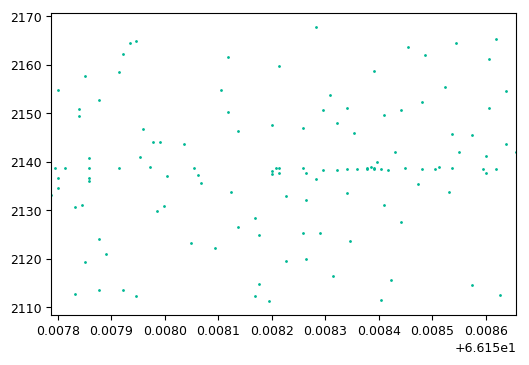

2600


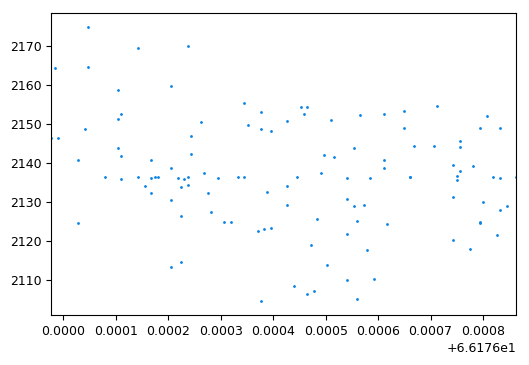

2700


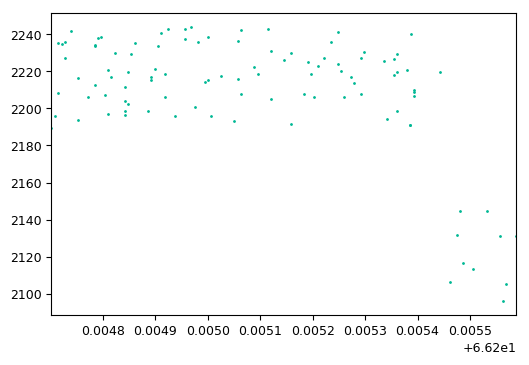

2800


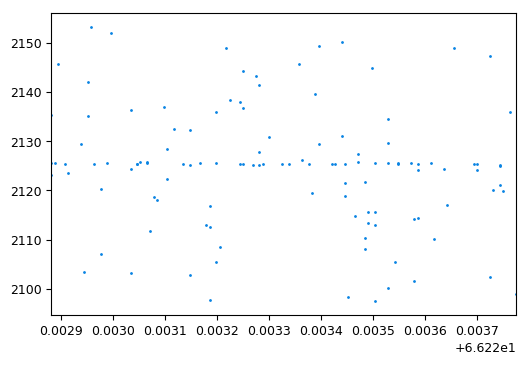

2900


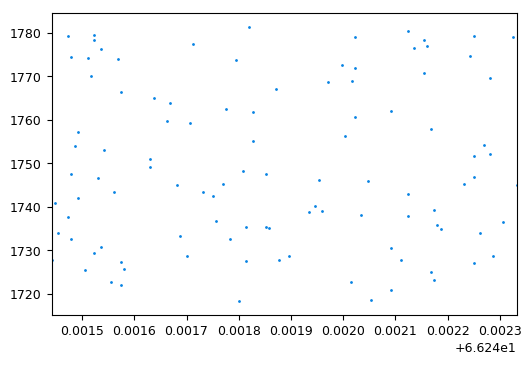

3000


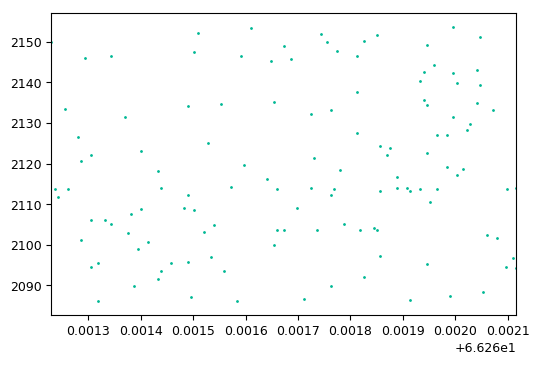

3100


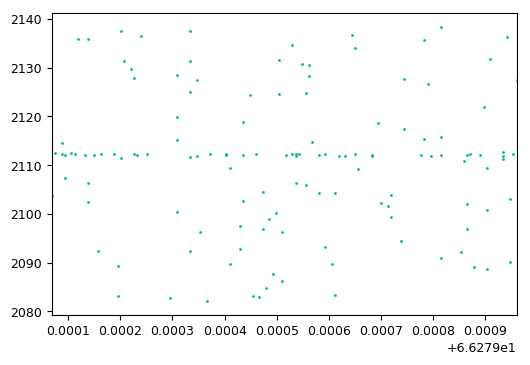

3200


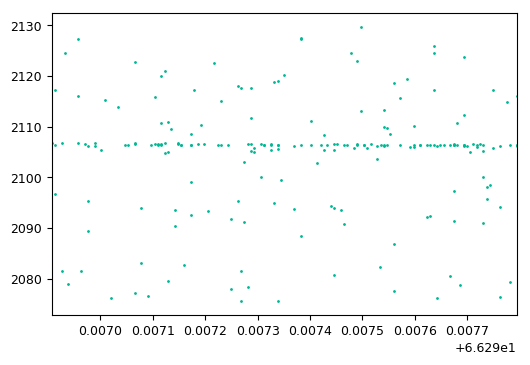

3300


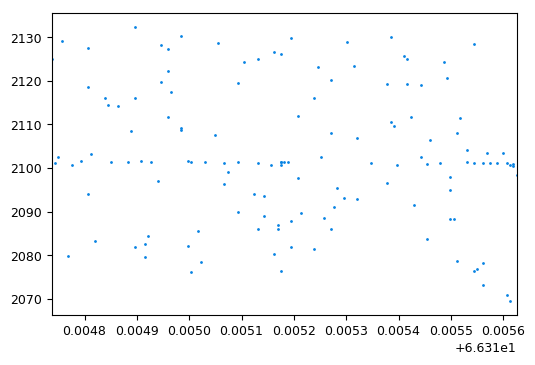

3400


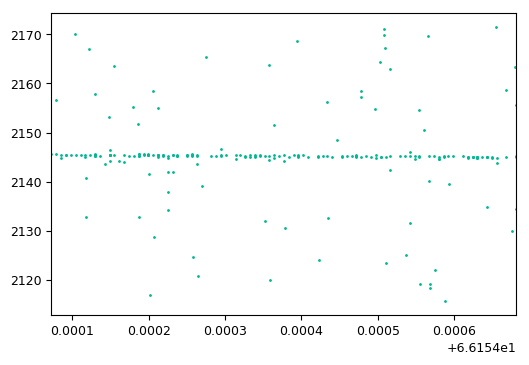

3500


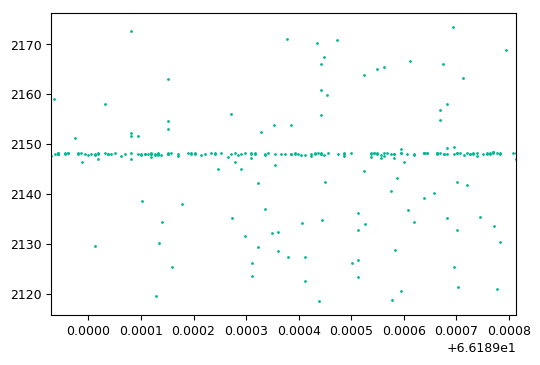

3600


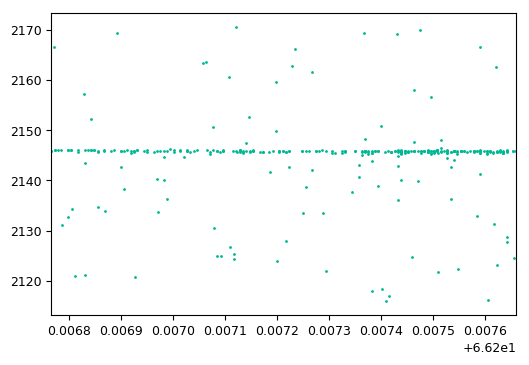

3700


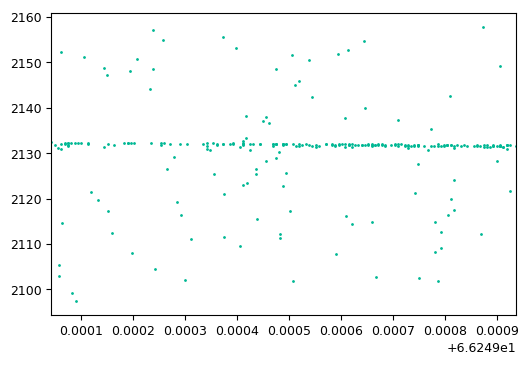

3800


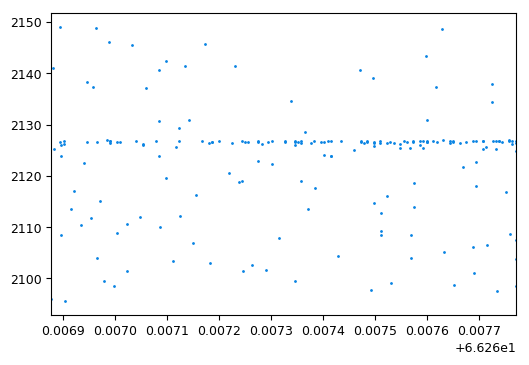

3900


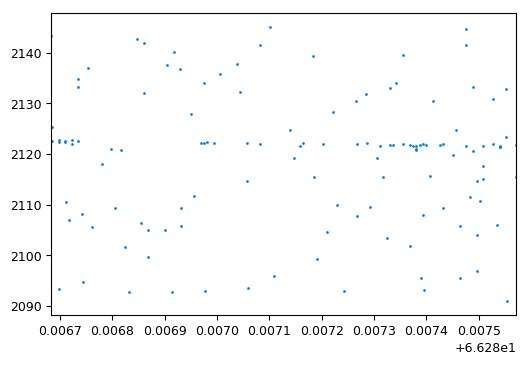

4000


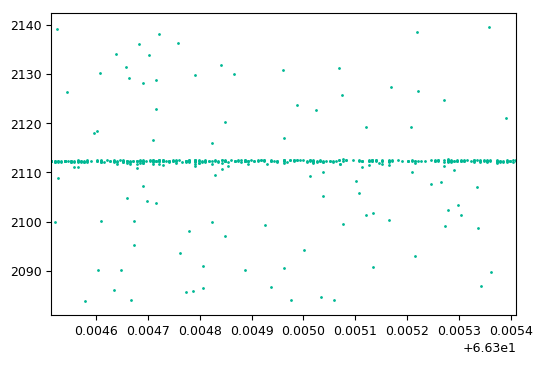

4100


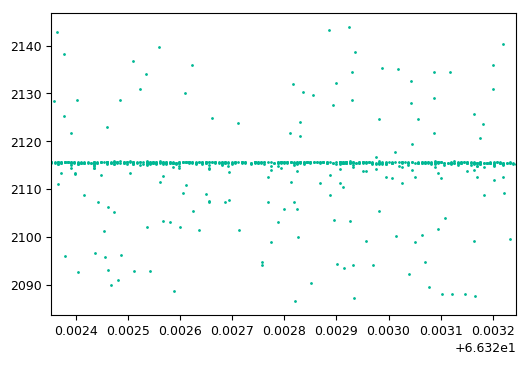

4200


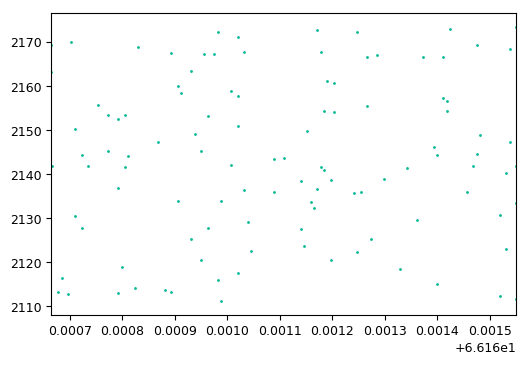

4300


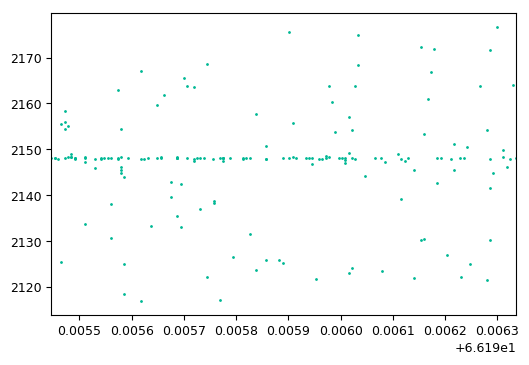

4400


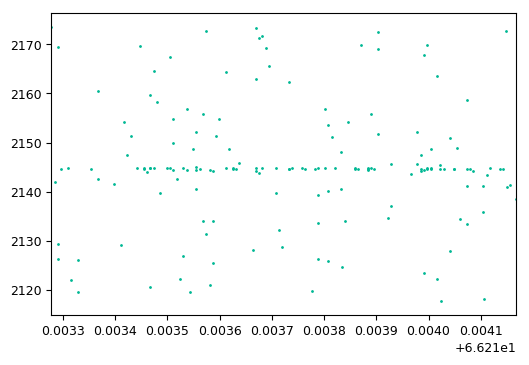

4500


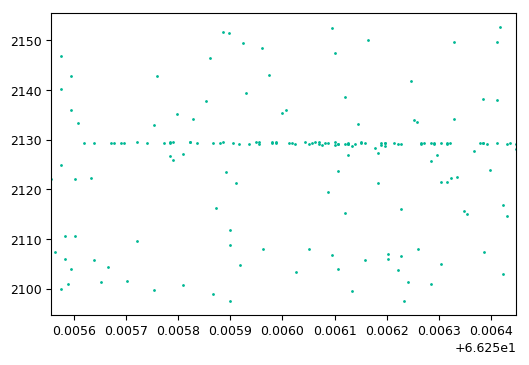

4600


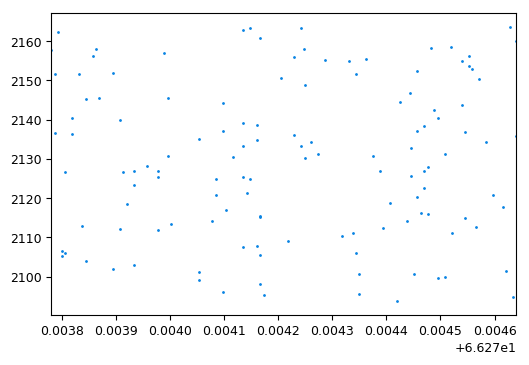

4700


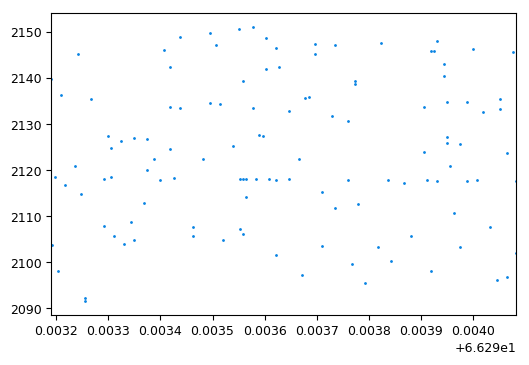

4800


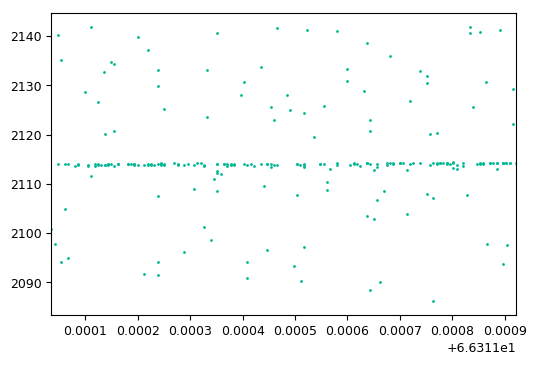

4900


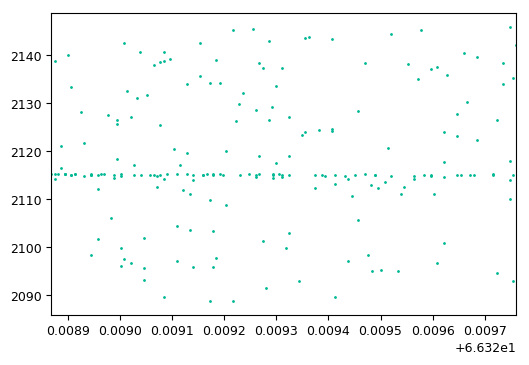

In [239]:
atl3_3 = {}
atl6_3["atl3_std"] = None
atl6_3["n_photons"] = None
 
# new small window
window_lat = delta_lat(my_lat, my_lon, 50)
window_lon = delta_lon(my_lat, my_lon, 50)   

for j, i in enumerate(atl6_3.index):
            
    my_row = atl6_3.loc[i]
    
    
    lat = float(my_row.lat)
    lon = float(my_row.lon)
    
    df = pho [ (pho["lat_ph"] < lat + window_lat) & (pho["lon_ph"] < lon + window_lon) &
               (pho["lat_ph"] > lat - window_lat) & (pho["lon_ph"] > lon - window_lon) ]
    
    atl3_3[i] = df
    
    if j % 100 == 0:
        print(j)
        ax2 = plt.scatter(df.lat_ph, df.h_ph, s = 1, c = cloud_color_VIIRS(float(my_row.Integer_Cloud_Mask)))
        #ax2 = plt.scatter(df.lat_ph, df.h_ph, s = 1, c = cloud_color_ATL(float(my_row.cloud_flg_asr))) 
        plt.xlim([min(df.lat_ph), max(df.lat_ph)])
        plt.show()
    
    ## Extra columns on the original ATL06 file
    
    atl6_3.loc[i, "atl3_std"] = np.std(df.h_ph)
    atl6_3.loc[i, "n_photons"] = df.shape[0]

Now, we observe a few measuraments that have really large values of standard desviation. These points correspond to measuraments where we have two different windows at which we are retrieving photons.

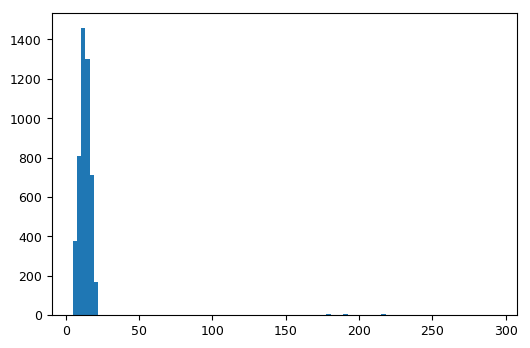

In [244]:
_ = plt.hist(list(atl6_3.atl3_std), 100)

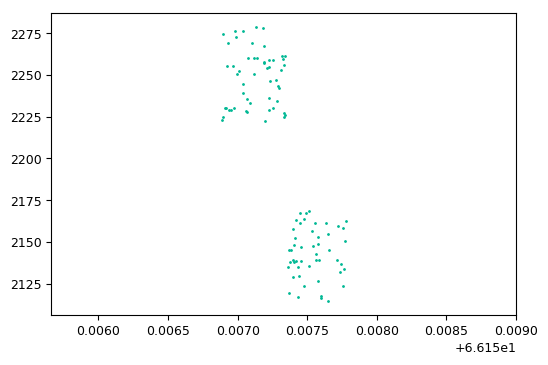

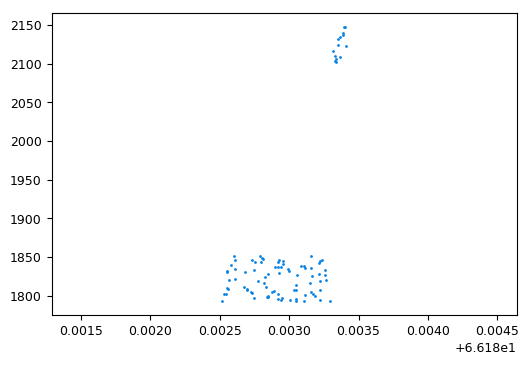

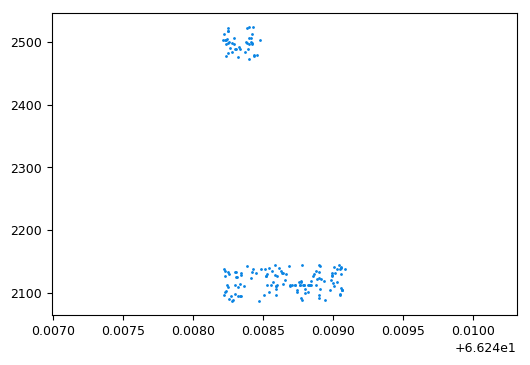

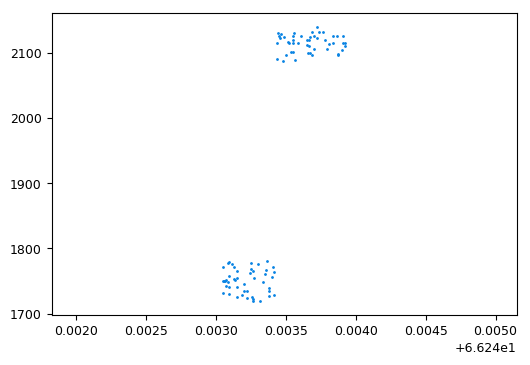

In [259]:
atl6_3_out = atl6_3[ atl6_3.atl3_std > 50 ]

for i in random.choice(atl6_3_out.index, 4):
    
    df = atl3_3[i]
    ax2 = plt.scatter(df.lat_ph, df.h_ph, s = 1, c = cloud_color_VIIRS(float(atl6_3_out.Integer_Cloud_Mask[i])))
    plt.show()

We restrict our analysis to measuramets with reasonable standard desviation.

In [262]:
atl6_3 = atl6_3[ atl6_3.atl3_std < 30 ]

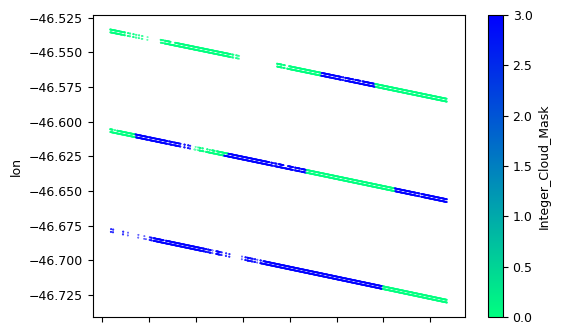

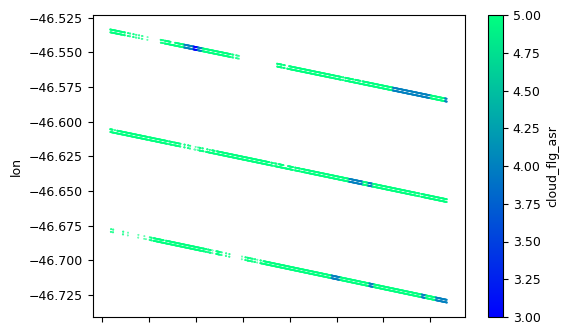

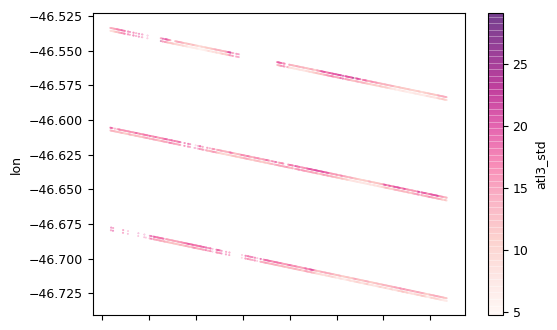

In [263]:
ax1 = atl6_3.plot.scatter(x='lat',
                          y='lon',
                          c='Integer_Cloud_Mask',
                          s = 0.1,  colormap='winter_r')
ax2 = atl6_3.plot.scatter(x='lat',
                          y='lon',
                          c='cloud_flg_asr',
                          s = 0.1,  colormap='winter')
ax2 = atl6_3.plot.scatter(x='lat',
                        y='lon',
                        c='atl3_std',
                        s = 0.1,  colormap='RdPu', alpha = 0.5)